In [2]:
!sudo apt update
!sudo apt install -y libcairo2-dev libpango1.0-dev pkg-config python3-dev

Sudo is disabled on this machine. To enable it, go to the ]8;;ms-settings:developers\Developer Settings page]8;;\ in the Settings app
Sudo is disabled on this machine. To enable it, go to the ]8;;ms-settings:developers\Developer Settings page]8;;\ in the Settings app


In [3]:
pip install manim

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\nicol\.pyenv\pyenv-win\versions\3.9.0\python.exe -m pip install --upgrade pip' command.


In [4]:
pip install ipynbname

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\nicol\.pyenv\pyenv-win\versions\3.9.0\python.exe -m pip install --upgrade pip' command.


In [5]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\nicol\.pyenv\pyenv-win\versions\3.9.0\python.exe -m pip install --upgrade pip' command.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time, pathlib, shutil
import ipynbname

from __future__ import annotations

from manim import config
config.preview = True

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from typing import Dict, List, Tuple
from math import log10, floor
from typing import Optional
from IPython.display import Video, display


def _u_Tminus1_poisson(lam: float, T: int) -> float:
    if T <= 1:
        return 0.0
    u = 0.0
    for _ in range(T - 1):
        u = float(np.exp(lam * (u - 1.0)))
    return u


def _zt_poisson(mu: float, rng: np.random.Generator) -> int:
    if mu <= 0.0:
        return 1
    if mu < 1.0:
        em = np.exp(-mu)
        U = rng.random() * (1.0 - em)
        p = em * mu
        c = p
        k = 1
        while c < U:
            k += 1
            p *= mu / k
            c += p
        return k
    # μ ≥ 1: reintentos
    k = 0
    while k == 0:
        k = int(rng.poisson(mu))
    return k


def _split_children_counts(N: int, z_parent: int, rng: np.random.Generator) -> np.ndarray:
    if N < 0.2 * z_parent:
        idx = rng.integers(0, z_parent, size=N)
        return np.bincount(idx, minlength=z_parent)
    return rng.multinomial(N, np.full(z_parent, 1.0 / z_parent))

c:\users\nicol\.pyenv\pyenv-win\versions\3.9.0\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [7]:
def GW_tree(lam: float,
            Z0: int = 1,
            max_gens: int = 100_000,
            rng: np.random.Generator | None = None,
            build_edges: bool = True
            ) -> Tuple[List[Tuple[int, int]], Dict[int, List[int]], int, List[int]]:
    if rng is None:
        rng = np.random.default_rng()

    if Z0 <= 0:
        return ([], {0: []}, 1, [0]) if build_edges else ([], {}, 1, [0])
    if lam <= 0:
        levels = {0: list(range(Z0))} if build_edges else {}
        return [], levels, 1, [Z0]

    edges: List[Tuple[int, int]] = []
    levels: Dict[int, List[int]] = {0: list(range(Z0))} if build_edges else {}
    sizes: List[int] = [Z0]
    next_id = Z0
    gens = 1

    while gens < max_gens:
        z_curr = sizes[-1]
        if z_curr == 0:
            break

        N = int(rng.poisson(lam * z_curr))
        if N == 0:
            sizes.append(0)
            gens += 1
            if build_edges:
                levels[gens - 1] = []
            break

        k = _split_children_counts(N, z_curr, rng)

        if build_edges:
            padres = levels[gens - 1]
            hijos_ids = np.arange(next_id, next_id + N, dtype=int)
            ps = np.cumsum(k)
            start = ps - k
            for i, cnt in enumerate(k):
                if cnt:
                    pid = padres[i]
                    a = start[i]
                    edges.extend((pid, int(ch)) for ch in hijos_ids[a:a + cnt])
            levels[gens] = hijos_ids.tolist()

        next_id += N
        sizes.append(N)
        gens += 1

    cuts = []
    return edges, levels, gens, sizes, cuts

In [8]:
def GW_tree_Miopic(lam: float,
                   T: int = 10,
                   Z0: int = 1,
                   max_gens: int = 2049,
                   rng: np.random.Generator | None = None,
                   build_edges: bool = True
                   ) -> Tuple[
                       List[Tuple[int, int]],
                       Dict[int, List[int]],
                       int,
                       List[int],
                       List[int]
                   ]:
    if rng is None:
        rng = np.random.default_rng()

    if Z0 <= 0:
        empty = ([], {0: []}, 1, [0], [])
        return empty if build_edges else ([], {}, 1, [0], [])
    if lam <= 0:
        levels = {0: list(range(Z0))} if build_edges else {}
        return [], levels, 1, [Z0], []

    edges: List[Tuple[int, int]] = []
    levels: Dict[int, List[int]] = {0: list(range(Z0))} if build_edges else {}
    sizes: List[int] = [Z0]
    cuts: List[int] = []
    gens = 1

    while gens < max_gens and sizes[-1] > 0:
        z_curr = sizes[-1]

        _, _, gens_sub, sizes_sub,_ = GW_tree(lam=lam, Z0=z_curr,
                                            max_gens=50_000, rng=rng,
                                            build_edges=False)

        if sizes_sub[-1] != 0:
            continue

        tau = gens_sub - 1
        if tau <= T:
            continue

        L = tau - T
        seg = sizes_sub[1:1 + L]
        room = max_gens - gens
        if room <= 0:
            break
        if len(seg) > room:
            seg = seg[:room]

        sizes.extend(seg)
        gens += len(seg)

        cuts.append(len(sizes) - 1)

    return edges, levels, gens, sizes, cuts

In [9]:
def draw_GW_tree(GW: Tuple[List[Tuple[int, int]], Dict[int, List[int]], int, List[int]]) -> None:
    t0 = time.perf_counter()
    edges, levels, gens, sizes,_ = GW
    if gens == 0:
        print("árbol vacío"); return

    xs, ys = {}, {}
    for g, nodes in levels.items():
        n = len(nodes)
        if n == 0:
            continue
        x_coords = np.linspace(-max(1, n) / 2, max(1, n) / 2, n)
        for x, v in zip(x_coords, nodes):
            xs[v], ys[v] = x, -g

    for u, v in edges:
        plt.plot([xs[u], xs[v]], [ys[u], ys[v]], c="grey", lw=0.5)
    plt.scatter(list(xs.values()), list(ys.values()), s=5, c="black")
    plt.axis("off")
    plt.show()

    sizes_arr = np.asarray(sizes, dtype=int)
    nz_idx = np.where(sizes_arr > 0)[0]
    g_last = int(nz_idx[-1]) if nz_idx.size else -1
    gens_activas = g_last + 1 if g_last >= 0 else 0

    print(f"n° de generaciones: {gens_activas}")
    if gens_activas > 0:
        y_act = sizes[:gens_activas]
        max_val = max(y_act)
        idx_max = [i for i, x in enumerate(y_act) if x == max_val]
        print(f"Gen Max: {max_val} individuos en n={idx_max}")
        print(f"Última no vacía: n={g_last} con {y_act[-1]} individuos.")
    else:
        print("Gen Max: 0 individuos")
        print("Última no vacía: n=-1 con 0 individuos.")

    elapsed = time.perf_counter() - t0
    hh = int(elapsed // 3600); mm = int((elapsed % 3600) // 60); ss = elapsed % 60
    print(f"ejecución en {hh}h {mm}m {ss:.2f}s")


def plot_GW_tree(GW: Tuple[List[Tuple[int, int]], Dict[int, List[int]], int, List[int], List[int]]) -> None:
    t0 = time.perf_counter()
    _, _, gens, sizes, cuts = GW
    if not sizes:
        print("árbol vacío"); return

    y = np.asarray(sizes, dtype=float)
    n = len(sizes)
    x = np.arange(n, dtype=float)

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.step(x, y, where="post", lw=1.2, solid_capstyle='butt', color="black")

    if n > 1:
        ax.set_xlim(-0.5, n - 0.5)
    else:
        ax.set_xlim(-0.5, 0.5)

    max_ticks = 12
    step = max(1, int(np.ceil(n / max_ticks)))
    xticks = np.arange(0, n, step)
    if xticks.size == 0 or xticks[-1] != n - 1:
        xticks = np.append(xticks, n - 1)
    ax.set_xticks(xticks)
    if n > 30:
        ax.tick_params(axis="x", labelsize=8)

    ymax = float(y.max()) if y.size else 1.0
    ax.set_ylim(0, ymax * 1.05 if ymax > 0 else 1.0)

    if cuts:
        for c in cuts:
            if 0 <= c < n:
                ax.axvline(x=c, color="limegreen", linestyle="--", linewidth=1.2, alpha=0.9)

    ax.set_xlabel("Generación n")
    ax.set_ylabel("Número de individuos $Z_n$")
    ax.grid(True, alpha=0.2, linewidth=0.6)
    plt.tight_layout()
    plt.show()

    nz_idx = np.where(y > 0)[0]
    g_last = int(nz_idx[-1]) if nz_idx.size else -1
    gens_activas = g_last + 1 if g_last >= 0 else 0

    print(f"n° de generaciones: {gens_activas}")
    if gens_activas > 0:
        y_act = sizes[:gens_activas]
        max_val = max(y_act)
        idx_max = [i for i, v in enumerate(y_act) if v == max_val]
        print(f"Gen Max: {max_val} individuos en n={idx_max}")
        print(f"Última no vacía: n={g_last} con {y_act[-1]} individuos.")
    else:
        print("Gen Max: 0 individuos")
        print("Última no vacía: n=-1 con 0 individuos.")

    if cuts:
        cuts_validos = [c for c in cuts if 0 <= c < n]
        print(f"Cortes (τ−T) dibujados en n = {cuts_validos}")

    elapsed = time.perf_counter() - t0
    hh = int(elapsed // 3600); mm = int((elapsed % 3600) // 60); ss = elapsed % 60
    print(f"ejecución en {hh}h {mm}m {ss:.2f}s")




def draw_GW_tree_bars(GW: Tuple[List[Tuple[int, int]], Dict[int, List[int]], int, List[int], List[int]]) -> None:
    t0 = time.perf_counter()
    _, _, _, sizes, cuts = GW
    if not sizes:
        print("árbol vacío"); return

    sizes_arr = np.asarray(sizes, dtype=int)
    nz_idx = np.where(sizes_arr > 0)[0]
    if nz_idx.size == 0:
        print("árbol vacío"); return

    g_last   = int(nz_idx[-1])
    sizes_act = sizes_arr[:g_last + 1]
    gens_act  = sizes_act.size

    x_margin = 0.01
    y_margin = 0.01
    target_w = 1.0 - 2.0 * x_margin
    target_h = 1.0 - 2.0 * y_margin
    zmax = int(sizes_act.max()) if sizes_act.size else 1

    k_len = target_w / max(1, zmax)
    k_h   = target_h / gens_act

    patches = []
    for g, z in enumerate(sizes_act):
        w = k_len * z
        x_left = -w / 2.0
        y_bot  = y_margin + g * k_h
        patches.append(Rectangle((x_left, y_bot), w, k_h))

    fig, ax = plt.subplots(figsize=(12, 8))
    pc = PatchCollection(patches, linewidths=0)
    pc.set_facecolor("black")
    ax.add_collection(pc)

    if cuts:
        cuts_act = [c for c in cuts if 0 <= c <= g_last]
        x0, x1 = -target_w/2, +target_w/2
        for c in cuts_act:
            y_mid = y_margin + (c + 0.5) * k_h  # centro de la barra c
            ax.plot([x0, x1], [y_mid, y_mid],
                    linestyle="--", color="limegreen", linewidth=1.2, alpha=0.9, zorder=5)

    ax.set_xlim(0.5, -0.5)
    ax.set_ylim(1, 0)
    ax.set_xticks([]); ax.set_yticks([])
    ax.axis('off')
    plt.show()

    print(f"n° de generaciones: {gens_act}")
    max_val = int(sizes_act.max())
    idx_max = [i for i, x in enumerate(sizes_act.tolist()) if x == max_val]
    print(f"Gen Max: {max_val} individuos en n={idx_max}")
    print(f"Última no vacía: n={g_last} con {int(sizes_act[-1])} individuos.")
    if cuts:
        cuts_act = [c for c in cuts if 0 <= c <= g_last]
        print(f"Cortes (τ−T) dibujados en n = {cuts_act}")
    elapsed = time.perf_counter() - t0
    hh = int(elapsed // 3600); mm = int((elapsed % 3600) // 60); ss = elapsed % 60
    print(f"ejecución en {hh}h {mm}m {ss:.2f}s")


# Quickstart (demo)


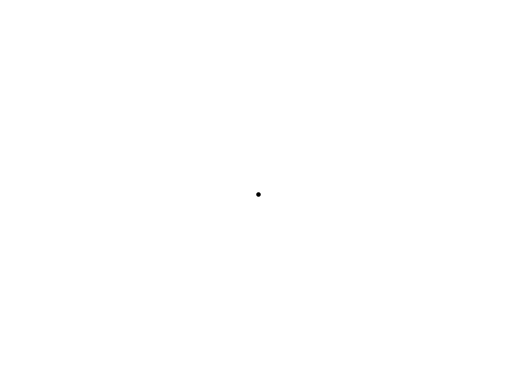

n° de generaciones: 1
Gen Max: 1 individuos en n=[0]
Última no vacía: n=0 con 1 individuos.
ejecución en 0h 0m 0.06s


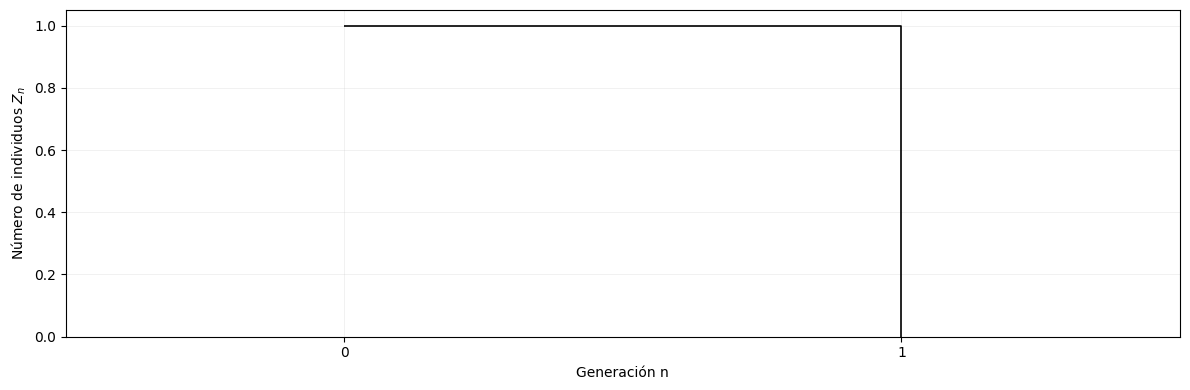

n° de generaciones: 1
Gen Max: 1 individuos en n=[0]
Última no vacía: n=0 con 1 individuos.
ejecución en 0h 0m 0.17s


In [10]:
# 1) GW estándar:
rng = np.random.default_rng(int(time.time_ns()))
GW = GW_tree(lam=1.0, Z0=1, max_gens=15000, rng=rng, build_edges=True)
draw_GW_tree(GW)
plot_GW_tree(GW)

In [11]:
# 2) GW miope con salto τ−T por iteración:
rng = np.random.default_rng(int(time.time()))
GWm = GW_tree_Miopic(lam=1.0, T=168, Z0=1, max_gens=15000, rng=rng, build_edges=False)
plot_GW_tree(GWm)
draw_GW_tree_bars(GWm)


KeyboardInterrupt



# MANIM

In [ ]:
from manim import *

lam       = 0.99
T         = 10
Z0        = 1
max_gens  = 250
seed      = int(time.time())
config.background_color = BLACK

def _resolve_notebook_dir():
    try:
        import ipynbname
        return ipynbname.path().parent
    except Exception:
        pass
    try:
        return pathlib.Path.cwd()
    except Exception:
        return pathlib.Path(".")

def _simulate_segment_poisson(lmbda: float, rng: np.random.Generator, z0: int = 1, max_len: int = 200_000):
    z = z0
    path = [z] if z > 0 else []
    steps = 0
    while z > 0 and steps < max_len:
        z = int(rng.poisson(lmbda * z))
        if z > 0:
            path.append(z)
        steps += 1
    return path

def _lam_tag(x: float) -> str:
    if float(x).is_integer(): return str(int(x))
    s = f"{x:.3f}".rstrip("0").rstrip(".")
    return s.replace(".", "p")

_rng = np.random.default_rng(seed)
segments, values_all = [], []
visible_len = 0
z_curr, first_seg = Z0, True
safety = 0

while visible_len < max_gens and safety < 100000:
    s = _simulate_segment_poisson(lam, _rng, z_curr)
    if len(s) <= T:
        safety += 1
        continue
    tau     = len(s)
    cut_pos = tau - T
    z_next  = s[cut_pos]
    s_draw  = s[0 if first_seg else 1:]
    segments.append(s_draw)
    values_all.extend(s_draw)
    visible_len += len(s_draw) - (T - 1)
    z_curr      = z_next
    first_seg   = False
    safety     += 1

if visible_len <= 0 or not segments:
    raise RuntimeError("No hubo segmentos aceptados con τ>T. Ajusta λ/T.")

N_FINAL = int(visible_len)

class GWMiopicFullHeightDynamicWidthInPlace(Scene):
    def construct(self):
        fw, fh = config.frame_width, config.frame_height
        bh  = fh / N_FINAL
        pxH = getattr(config, "pixel_height", 1080)
        EPS = 1 * fh / pxH
        H   = bh + 2*EPS
        bars, values, colors = [], [], []

        def _y_for_index(i: int) -> float:
            return fh/2 - (i + 0.5) * bh

        def _rect_at(i: int, z: int, col, zmax: int):
            w = (z / zmax) * fw
            r = Rectangle(width=w, height=H).set_fill(col, opacity=1.0).set_stroke(width=0)
            r.move_to([0, _y_for_index(i), 0])
            return r

        def _update_widths_only(run_time=0.05):
            if not bars: return
            zmax = max(values)
            anims = []
            for i,(rect,z,col) in enumerate(zip(bars, values, colors)):
                anims.append(Transform(rect, _rect_at(i, z, col, zmax)))
            self.play(*anims, run_time=run_time)

        def _compact_and_update(run_time=0.08):
            if not bars: return
            zmax = max(values)
            anims = []
            for i,(rect,z,col) in enumerate(zip(bars, values, colors)):
                anims.append(Transform(rect, _rect_at(i, z, col, zmax)))
            self.play(*anims, run_time=run_time)

        for seg_idx, s_draw in enumerate(segments):
            if len(bars) >= N_FINAL: break
            for j, z in enumerate(s_draw):
                if len(bars) >= N_FINAL: break
                col = BLUE if (seg_idx == 0 and j == 0) else WHITE
                values.append(z); colors.append(col)
                zmax_now = max(values)
                i = len(bars)
                if z == zmax_now and i > 0:
                    _update_widths_only(run_time=0.04)
                r = _rect_at(i, z, col, zmax_now)
                bars.append(r)
                self.play(FadeIn(r), run_time=0.06)

            if not bars:
                continue

            last = bars[-1]
            self.play(last.animate.set_fill(RED),   run_time=0.08)
            self.play(last.animate.set_fill(WHITE), run_time=0.08)
            colors[-1] = WHITE

            cut_idx = len(bars) - T
            cut_idx = max(0, min(cut_idx, len(bars)-1))
            to_prune = list(range(cut_idx + 1, len(bars)))
            if to_prune:
                for _ in range(3):
                    self.play(*[bars[k].animate.set_fill(RED)   for k in to_prune], run_time=0.06)
                    self.play(*[bars[k].animate.set_fill(WHITE) for k in to_prune], run_time=0.06)
                self.play(*[FadeOut(bars[k]) for k in to_prune], run_time=0.14)
                for k in reversed(to_prune):
                    bars.pop(k); values.pop(k); colors.pop(k)
                _compact_and_update(run_time=0.08)

            self.play(bars[cut_idx].animate.set_fill(GREEN), run_time=0.10)
            colors[cut_idx] = GREEN

            if len(bars) >= N_FINAL:
                break

        self.wait(0.25)

In [ ]:
NB_PATH = ipynbname.path()
NB_DIR  = NB_PATH.parent

file_stem = f"GW_miopic_poi{_lam_tag(lam)}_T{T}"

out_dir = NB_DIR / "media"
out_dir.mkdir(parents=True, exist_ok=True)

config.verbosity   = "WARNING"
config.output_file = file_stem
config.media_dir   = str(out_dir)

scene = GWMiopicFullHeightDynamicWidthInPlace()
scene.render()

mp4_src = getattr(scene.renderer.file_writer, "movie_file_path")
mp4_dst = out_dir / f"{file_stem}.mp4"

try:
    shutil.copy2(mp4_src, mp4_dst)
except:
    pass

display(Video(str(mp4_dst), embed=True))
print("✅ Guardado en:", mp4_dst)

In [ ]:
from manim import *

lam       = 0.999
T         = 168
Z0        = 1
max_gens  = 1000
seed      = int(time.time())
config.background_color = BLACK

def _simulate_segment_poisson(lmbda: float, rng: np.random.Generator, z0: int = 1, max_len: int = 200_000):
    z = z0
    path = [z] if z > 0 else []
    steps = 0
    while z > 0 and steps < max_len:
        z = int(rng.poisson(lmbda * z))
        if z > 0:
            path.append(z)
        steps += 1
    return path

def _lam_tag(x: float) -> str:
    if float(x).is_integer(): return str(int(x))
    s = f"{x:.3f}".rstrip("0").rstrip(".")
    return s.replace(".", "p")

def _nice_step(max_val: float, target_ticks: int = 8) -> int:
    if max_val <= 0:
        return 1
    raw = max_val / max(1, target_ticks)
    p = 10**floor(log10(raw))
    for m in (1, 2, 5, 10):
        if m * p >= raw:
            return int(max(1, m * p))
    return int(max(1, 10 * p))

rng = np.random.default_rng(seed)

script = []
values_all = []
final_values = []
len_kept_so_far = 0
max_len_temp = 0

z_curr, first_seg = Z0, True
safety = 0
while len(final_values) < max_gens and safety < 200000:
    s = _simulate_segment_poisson(lam, rng, z_curr)
    if len(s) <= T:
        safety += 1
        continue

    tau     = len(s)
    cut_pos = tau - T
    z_next  = s[cut_pos]

    start_idx  = 0 if first_seg else 1
    s_draw     = s[start_idx:]
    keep_total = max(0, len(s_draw) - (T - 1))
    cap        = max_gens - len(final_values)
    add_kept   = min(keep_total, cap)
    kept_vals  = s_draw[:add_kept]
    pruned_vals = s_draw[keep_total:] if (add_kept == keep_total) else []

    values_all.extend(s_draw)
    max_len_temp = max(max_len_temp, len_kept_so_far + len(s_draw))
    len_kept_so_far += add_kept
    final_values.extend(kept_vals)

    script.append(dict(s_draw=s_draw, kept_vals=kept_vals, pruned_vals=pruned_vals, keep_total=add_kept))

    z_curr    = z_next
    first_seg = False
    safety   += 1

if not final_values:
    raise RuntimeError("No hubo bloques aceptados (τ≤T). Ajusta λ/T.")

N_FINAL      = len(final_values)
Z_MAX_GLOBAL = max(values_all) if values_all else 1
X_MAX_TEMP   = max(max_len_temp, N_FINAL) + 1

def make_step_vmobject(axes: Axes, x_start: int, y_prev: int | None, values: list[int],
                       color=WHITE, width=2):
    pts = []
    x = x_start
    if not values:
        m = VMobject().set_stroke(color=color, width=width).set_fill(opacity=0)
        return m
    if y_prev is None:
        y = values[0]
        pts += [axes.c2p(x, y), axes.c2p(x+1, y)]
        x += 1
        for z in values[1:]:
            pts += [axes.c2p(x, z), axes.c2p(x+1, z)]
            x += 1
    else:
        y = y_prev
        pts += [axes.c2p(x, y), axes.c2p(x, values[0])]
        y = values[0]
        pts += [axes.c2p(x+1, y)]
        x += 1
        for z in values[1:]:
            pts += [axes.c2p(x, z), axes.c2p(x+1, z)]
            x += 1
    m = VMobject().set_stroke(color=color, width=width).set_fill(opacity=0)
    m.set_points_as_corners(pts)
    return m

def make_pruned_area_polygon(axes: Axes, x_start: int, z_list: list[int],
                             color=RED, alpha=0.30):
    if not z_list:
        return Polygon(axes.c2p(0,0), axes.c2p(0,0)).set_stroke(width=0).set_fill(opacity=0)
    pts = [axes.c2p(x_start, 0), axes.c2p(x_start, z_list[0]), axes.c2p(x_start+1, z_list[0])]
    x = x_start + 1
    for i in range(len(z_list)-1):
        pts += [axes.c2p(x, z_list[i+1]), axes.c2p(x+1, z_list[i+1])]
        x += 1
    pts += [axes.c2p(x, 0), axes.c2p(x_start, 0)]
    return Polygon(*pts).set_stroke(width=0).set_fill(color=color, opacity=alpha)

# -------- Escena --------
class GWMiopicGraph(Scene):
    def construct(self):
        fw, fh = config.frame_width, config.frame_height

        step_x = max(1, _nice_step(X_MAX_TEMP, target_ticks=10))
        step_y = max(1, _nice_step(Z_MAX_GLOBAL, target_ticks=6))

        plane = NumberPlane(
            x_range=[0, X_MAX_TEMP, step_x],
            y_range=[0, Z_MAX_GLOBAL * 1.05 if Z_MAX_GLOBAL > 0 else 1, step_y],
            background_line_style=dict(stroke_color=GREY_C, stroke_width=1, stroke_opacity=0.18),
            axis_config=dict(stroke_width=0)
        )
        plane.width  = fw * 0.92
        plane.height = fh * 0.80
        plane.move_to(ORIGIN)

        axes = Axes(
            x_range=[0, X_MAX_TEMP, step_x],
            y_range=[0, Z_MAX_GLOBAL * 1.05 if Z_MAX_GLOBAL > 0 else 1, step_y],
            axis_config={"include_ticks": True, "include_numbers": False, "stroke_color": GREY_E, "stroke_width": 2},
            tips=False
        )
        axes.width  = plane.width
        axes.height = plane.height
        axes.move_to(plane.get_center())

        x_label = Text("Generación", color=GREY_B, font_size=20).next_to(axes.x_axis, DOWN, buff=0.35)
        y_label = Text("Número de individuos", color=GREY_B, font_size=20)\
                    .rotate(90 * DEGREES).next_to(axes.y_axis, LEFT, buff=0.57)

        self.add(plane, axes, x_label, y_label)

        def _add_text_ticks():
            # X
            x_vals = list(range(0, int(X_MAX_TEMP)+1, step_x))
            for xv in x_vals:
                txt = Text(str(xv), font_size=22, color=GREY_B)
                txt.next_to(axes.c2p(xv, 0), DOWN, buff=0.15)
                self.add(txt)
            # Y
            y_vals = list(range(0, int(Z_MAX_GLOBAL * 1.05) + 1, step_y))
            for yv in y_vals:
                txt = Text(str(yv), font_size=22, color=GREY_B)
                txt.next_to(axes.c2p(0, yv), LEFT, buff=0.15)
                self.add(txt)

        _add_text_ticks()

        kept_parts = VGroup()
        y_last = None
        x_cursor = 0

        for blk in script:
            kept_vals   = blk["kept_vals"]
            pruned_vals = blk["pruned_vals"]

            line_kept = make_step_vmobject(axes, x_start=x_cursor, y_prev=y_last,
                                           values=kept_vals, color=WHITE, width=2)
            self.play(Create(line_kept), run_time=max(0.035 * len(kept_vals), 0.06))
            self.add(line_kept)
            kept_parts.add(line_kept)

            if kept_vals:
                y_last = kept_vals[-1]
                x_cursor += len(kept_vals)

            if pruned_vals:
                line_pruned = make_step_vmobject(axes, x_start=x_cursor, y_prev=y_last,
                                                 values=pruned_vals, color=WHITE, width=2)
                self.play(Create(line_pruned), run_time=max(0.001 * len(pruned_vals), 0.06))

                area = make_pruned_area_polygon(axes, x_start=x_cursor, z_list=pruned_vals, color=RED, alpha=0.30)
                self.add(area)
                for _ in range(3):
                    self.play(area.animate.set_fill(RED, opacity=0.80), run_time=0.07)
                    self.play(area.animate.set_fill(RED, opacity=0.30), run_time=0.07)

                self.play(FadeOut(line_pruned), FadeOut(area), run_time=0.16)
                self.remove(line_pruned, area)

            cut_x = x_cursor
            vline = Line(
                axes.c2p(cut_x, 0),
                axes.c2p(cut_x, Z_MAX_GLOBAL * 1.02),
                color=GREEN,
                stroke_width=2,
            )
            self.play(Create(vline), run_time=0.10)

        self.wait(0.30)

In [ ]:
NB_PATH = ipynbname.path()
NB_DIR  = NB_PATH.parent

file_stem = f"GW_miopic_graph_poi{_lam_tag(lam)}_T{T}"

out_dir = NB_DIR / "media"
out_dir.mkdir(parents=True, exist_ok=True)

config.verbosity   = "WARNING"
config.output_file = file_stem
config.media_dir   = str(out_dir)

scene = GWMiopicGraph()
scene.render()

mp4_src = getattr(scene.renderer.file_writer, "movie_file_path")
mp4_dst = out_dir / f"{file_stem}.mp4"

try:
    shutil.copy2(mp4_src, mp4_dst)
except:
    pass

display(Video(str(mp4_dst), embed=True))
print("✅ Guardado en:", mp4_dst)

##Nico

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time, pathlib, shutil
import ipynbname

from __future__ import annotations

from manim import config
config.preview = True

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from typing import Dict, List, Tuple
from math import log10, floor
from typing import Optional
from IPython.display import Video, display

In [6]:
def build_tree_layout(
    edges: List[Tuple[int, int]],
    levels: Dict[int, List[int]],
    x_spacing: float = 1.0,
    y_spacing: float = 1.3,
):
    vertices_set = set()
    for u, v in edges:
        vertices_set.add(u)
        vertices_set.add(v)
    for lvl_nodes in levels.values():
        vertices_set.update(lvl_nodes)

    if not vertices_set:
        return [], {}

    vertices = sorted(vertices_set)

    from collections import defaultdict
    children = defaultdict(list)
    for u, v in edges:
        children[u].append(v)

    if 0 in levels and len(levels[0]) > 0:
        roots = list(levels[0])
    else:
        child_set = {v for _, v in edges}
        roots = [v for v in vertices if v not in child_set]

    width_cache = {}

    def compute_width(v: int) -> int:
        if v in width_cache:
            return width_cache[v]
        childs = children.get(v, [])
        if not childs:
            w = 1
        else:
            w = sum(compute_width(c) for c in childs)
        width_cache[v] = w
        return w

    for r in roots:
        compute_width(r)

    layout = {}
    gap_units = 1
    total_units = sum(width_cache[r] for r in roots) + gap_units * (len(roots) - 1)
    x_cursor = - total_units / 2.0

    def assign_positions(v: int, x_left: float, x_right: float, depth: int):
        x_center_units = (x_left + x_right) / 2.0
        x = x_center_units * x_spacing
        y = - depth * y_spacing
        layout[v] = np.array([x, y, 0.0])

        childs = children.get(v, [])
        if not childs:
            return

        child_left = x_left
        for c in childs:
            w_c = width_cache[c]
            child_right = child_left + w_c
            assign_positions(c, child_left, child_right, depth + 1)
            child_left = child_right

    for r in roots:
        w_r = width_cache[r]
        x_left_r = x_cursor
        x_right_r = x_cursor + w_r
        assign_positions(r, x_left_r, x_right_r, depth=0)
        x_cursor = x_right_r + gap_units

    return vertices, layout


def build_naive_tree_graph(
    GW_naive_output,
    x_spacing: float = 1.0,
    y_spacing: float = 1.3,
) -> Graph:
    edges, levels, gens, sizes, cuts = GW_naive_output

    vertices, layout = build_tree_layout(
        edges=edges,
        levels=levels,
        x_spacing=x_spacing,
        y_spacing=y_spacing,
    )

    if not vertices:
        return Graph(vertices=[], edges=[])

    vertex_config = {
        v: {"radius": 0.07, "fill_color": WHITE}
        for v in vertices
    }

    root_nodes = levels.get(0, [])
    for r in root_nodes:
        if r in vertex_config:
            vertex_config[r].update({"radius": 0.09, "fill_color": YELLOW})

    edge_config = {
        "stroke_width": 1.5,
        "stroke_opacity": 0.9,
    }

    graph = Graph(
        vertices=vertices,
        edges=edges,
        layout=layout,
        layout_scale=1.0,
        vertex_config=vertex_config,
        edge_config=edge_config,
    )

    return graph


In [7]:
from manim import *
import numpy as np
from collections import defaultdict
from typing import Dict, List, Tuple


def build_tree_layout(
    edges: List[Tuple[int, int]],
    levels: Dict[int, List[int]],
    x_spacing: float = 1.0,
    y_spacing: float = 1.3,
) -> Tuple[List[int], Dict[int, np.ndarray]]:
    """
    Construye un layout 'limpio' y jerárquico para un árbol/ bosque:
      - una generación por fila (descendiendo en -y),
      - hijos debajo de sus padres,
      - subárboles contiguos en x.

    Parámetros
    ----------
    edges : lista de aristas (padre, hijo)
    levels : diccionario {generación: [lista de vértices en esa generación]}
    x_spacing : separación horizontal básica entre hojas (en unidades de escena)
    y_spacing : separación vertical entre generaciones

    Devuelve
    --------
    vertices : lista con todos los vértices
    layout   : diccionario {vértice: np.array([x, y, 0])}
    """
    # --- 1. Conjunto de vértices y estructura de hijos ---
    vertices_set = set()
    for u, v in edges:
        vertices_set.add(u)
        vertices_set.add(v)
    for lvl_nodes in levels.values():
        vertices_set.update(lvl_nodes)

    if not vertices_set:
        # Árbol vacío
        return [], {}

    vertices = sorted(vertices_set)

    children = defaultdict(list)
    for u, v in edges:
        children[u].append(v)

    # Conjunto de posibles raíces: si tenemos levels[0], lo usamos;
    # si no, raíces = vértices que nunca aparecen como hijos.
    if 0 in levels and len(levels[0]) > 0:
        roots = list(levels[0])
    else:
        child_set = {v for _, v in edges}
        roots = [v for v in vertices if v not in child_set]

    # --- 2. Ancho (en "unidades de hoja") de cada subárbol ---
    width_cache: Dict[int, int] = {}

    def compute_width(v: int) -> int:
        if v in width_cache:
            return width_cache[v]
        childs = children.get(v, [])
        if not childs:
            w = 1
        else:
            w = sum(compute_width(c) for c in childs)
        width_cache[v] = w
        return w

    for r in roots:
        compute_width(r)

    # --- 3. Asignación recursiva de posiciones ---
    layout: Dict[int, np.ndarray] = {}
    gap_units = 1  # espacio vacío entre subárboles raíz
    total_units = sum(width_cache[r] for r in roots) + gap_units * (len(roots) - 1)
    x_cursor = - total_units / 2.0  # centramos todo el bosque

    def assign_positions(v: int, x_left: float, x_right: float, depth: int) -> None:
        x_center_units = (x_left + x_right) / 2.0
        x = x_center_units * x_spacing
        y = - depth * y_spacing

        layout[v] = np.array([x, y, 0.0])

        childs = children.get(v, [])
        if not childs:
            return

        child_left = x_left
        for c in childs:
            w_c = width_cache[c]
            child_right = child_left + w_c
            assign_positions(c, child_left, child_right, depth + 1)
            child_left = child_right

    for r in roots:
        w_r = width_cache[r]
        x_left_r = x_cursor
        x_right_r = x_cursor + w_r
        assign_positions(r, x_left_r, x_right_r, depth=0)
        x_cursor = x_right_r + gap_units

    return vertices, layout



In [8]:
class NaiveMyopicGWTreeScene(Scene):
    def construct(self):
        # Parámetros del proceso
        lam = 1.2
        T = 10
        Z0 = 1
        max_gens = 10   # pocas generaciones para visualización

        rng = np.random.default_rng(123)

        # 1. Simulación del árbol miope (medida naive)
        edges, levels, gens, sizes, cuts = GW_tree_naive_myopic(
            lam=lam,
            T=T,
            Z0=Z0,
            max_gens=max_gens,
            rng=rng,
            build_edges=True,
        )

        # 2. Construcción del grafo con layout jerárquico
        tree_graph = build_naive_tree_graph(
            (edges, levels, gens, sizes, cuts),
            x_spacing=1.0,
            y_spacing=1.3,
        )

        tree_graph.scale_to_fit_height(5)
        tree_graph.move_to(ORIGIN)

        # 3. Títulos
        title = Text(
            f"Árbol GW miope – medida naive (λ={lam:.2f}, T={T})",
            font_size=32,
        ).to_edge(UP)

        sizes_text = Text(
            ", ".join(f"Z_{n}={z}" for n, z in enumerate(sizes)),
            font_size=24,
        ).to_edge(DOWN)

        self.play(Write(title))
        self.play(FadeIn(sizes_text))

        # 4. Diccionario de aristas: (u, v) -> mobject de la arista
        edge_mobs_dict = {key: mob for key, mob in tree_graph.edges.items()}

        # 5. Animación nivel por nivel
        # ----------------------------
        # Nivel 0 (raíz)
        gen0_nodes = levels.get(0, [])
        gen0_vertex_mobs = [tree_graph[v] for v in gen0_nodes]

        self.play(
            LaggedStart(
                *[FadeIn(vm) for vm in gen0_vertex_mobs],
                lag_ratio=0.01,
                run_time=0.2,
            )
        )
        self.wait(0.05)

        # Niveles siguientes
        max_level = max(levels.keys())
        for g in range(1, max_level + 1):
            nodes_g = levels.get(g, [])
            if not nodes_g:
                continue

            # vértices de la generación g
            verts_g = [tree_graph[v] for v in nodes_g]

            # aristas que llegan a esta generación
            edges_g = [
                edge_mobs_dict[(u, v)]
                for (u, v) in edges
                if v in nodes_g
            ]

            # 5a. Primero aparecen los nodos hijos
            self.play(
                LaggedStart(
                    *[FadeIn(v) for v in verts_g],
                    lag_ratio=0.1,
                    run_time=0.5,
                )
            )

            # 5b. Después se trazan lentamente las aristas padre→hijo
            self.play(
                LaggedStart(
                    *[Create(e) for e in edges_g],
                    lag_ratio=0.05,   # controla el “uno por uno”
                    run_time=0.05,     # controla la velocidad global
                )
            )

            self.wait(0.2)

        self.wait(0.1)

        # 6. Opcional: resaltar la raíz principal
        root_nodes = levels.get(0, [])
        if root_nodes:
            root = root_nodes[0]
            root_dot = tree_graph[root]
            halo = Circle(radius=0.2).move_to(root_dot).set_stroke(width=2)
            self.play(Indicate(root_dot), Create(halo), run_time=1.5)
            self.wait(1)

        self.wait(2)


In [9]:
def make_sizes_label(
    sizes,
    max_terms: int = 21,
    per_line: int = 7,
    font_size: int = 24,
) -> VGroup:
    """
    Construye un rótulo con los Z_n en varias filas.

    - max_terms: máximo número de pares (n, Z_n) a mostrar.
    - per_line: cuántos términos por fila.
    """
    pairs = list(enumerate(sizes))
    add_ellipsis = False
    if len(pairs) > max_terms:
        pairs = pairs[:max_terms]
        add_ellipsis = True

    # Partimos en bloques de per_line términos
    chunks = [pairs[i:i + per_line] for i in range(0, len(pairs), per_line)]
    lines = []
    for i, chunk in enumerate(chunks):
        text_str = ", ".join(f"Z_{n}={z}" for n, z in chunk)
        if add_ellipsis and i == len(chunks) - 1:
            text_str += ", ..."
        line = Text(text_str, font_size=font_size)
        lines.append(line)

    label = VGroup(*lines)
    label.arrange(DOWN, aligned_edge=LEFT, buff=0.05)
    label.to_edge(DOWN)
    return label


In [10]:
class NaiveMyopicGWTreeScene(Scene):
    def construct(self):
        # Parámetros del proceso
        lam = 0.8      # λ más pequeño
        T = 10
        Z0 = 1
        max_gens = 15  # ahora 15 generaciones

        rng = np.random.default_rng(123)

        # 1. Simulación del árbol miope (medida naive)
        edges, levels, gens, sizes, cuts = GW_tree_naive_myopic(
            lam=lam,
            T=T,
            Z0=Z0,
            max_gens=max_gens,
            rng=rng,
            build_edges=True,
        )

        # 2. Construcción del grafo con layout jerárquico
        tree_graph = build_naive_tree_graph(
            (edges, levels, gens, sizes, cuts),
            x_spacing=1.0,
            y_spacing=1.0,   # separación vertical moderada
        )

        # Escalamos para que quepa razonablemente
        tree_graph.scale_to_fit_height(5)
        if tree_graph.width > 12:
            tree_graph.scale_to_fit_width(12)
        tree_graph.move_to(ORIGIN)

        # 3. Títulos
        title = Text(
            f"Árbol GW miope – medida naive (λ={lam:.2f}, T={T})",
            font_size=32,
        ).to_edge(UP)

        # Mostramos, por ejemplo, hasta 15 términos Z_n repartidos en varias filas
        sizes_label = make_sizes_label(
            sizes,
            max_terms=15,   # como antes: hasta Z_14
            per_line=5,     # 5 términos por fila → 3 filas máximo
            font_size=24,
        )

        self.play(Write(title), run_time=0.7)
        self.play(FadeIn(sizes_label), run_time=0.7)

        # 4. Diccionario de aristas: (u, v) -> mobject de la arista
        edge_mobs_dict = {key: mob for key, mob in tree_graph.edges.items()}

        # 5. Animación nivel por nivel
        # ----------------------------
        # Nivel 0 (raíz)
        gen0_nodes = levels.get(0, [])
        gen0_vertex_mobs = [tree_graph[v] for v in gen0_nodes]

        self.play(
            LaggedStart(
                *[FadeIn(vm) for vm in gen0_vertex_mobs],
                lag_ratio=0.05,
                run_time=0.6,
            )
        )
        self.wait(0.1)

        # Niveles siguientes
        max_level = max(levels.keys())
        for g in range(1, max_level + 1):
            nodes_g = levels.get(g, [])
            if not nodes_g:
                continue

            verts_g = [tree_graph[v] for v in nodes_g]

            edges_g = [
                edge_mobs_dict[(u, v)]
                for (u, v) in edges
                if v in nodes_g
            ]

            # 5a. Primero aparecen los nodos hijos (rápido)
            self.play(
                LaggedStart(
                    *[FadeIn(v) for v in verts_g],
                    lag_ratio=0.03,
                    run_time=0.4,
                )
            )

            # 5b. Luego se trazan las aristas padre→hijo, también más rápido
            self.play(
                LaggedStart(
                    *[Create(e) for e in edges_g],
                    lag_ratio=0.03,
                    run_time=0.5,
                )
            )

        self.wait(0.8)

        # 6. Opcional: resaltar la raíz principal
        root_nodes = levels.get(0, [])
        if root_nodes:
            root = root_nodes[0]
            root_dot = tree_graph[root]
            halo = Circle(radius=0.2).move_to(root_dot).set_stroke(width=2)
            self.play(Indicate(root_dot), Create(halo), run_time=0.8)
            self.wait(0.5)

        self.wait(0.8)


In [11]:
def make_sizes_label(
    sizes,
    max_terms: int = 21,
    per_line: int = 7,
    font_size: int = 24,
) -> VGroup:
    """
    Construye un rótulo con los Z_n en varias filas.

    - max_terms: máximo número de pares (n, Z_n) a mostrar.
    - per_line: cuántos términos por fila.
    """
    pairs = list(enumerate(sizes))
    add_ellipsis = False
    if len(pairs) > max_terms:
        pairs = pairs[:max_terms]
        add_ellipsis = True

    chunks = [pairs[i:i + per_line] for i in range(0, len(pairs), per_line)]
    lines = []
    for i, chunk in enumerate(chunks):
        text_str = ", ".join(f"Z_{n}={z}" for n, z in chunk)
        if add_ellipsis and i == len(chunks) - 1:
            text_str += ", ..."
        line = Text(text_str, font_size=font_size)
        lines.append(line)

    label = VGroup(*lines)
    label.arrange(DOWN, aligned_edge=LEFT, buff=0.05)
    label.to_edge(DOWN)
    return label


In [12]:
def partial_tree_bbox(levels, g, tree_graph, margin: float = 1.2):
    """
    Para niveles 0..g, calcula:
      - centro del bounding box,
      - ancho sugerido para el frame de la cámara.

    margin > 1 amplía un poco la caja para que no quede todo pegado al borde.
    """
    node_ids = []
    for k in range(g + 1):
        node_ids += levels.get(k, [])

    if not node_ids:
        # caso degenerado: devolvemos algo razonable
        return ORIGIN, 4.0

    pts = [tree_graph[v].get_center() for v in node_ids]
    xs = [p[0] for p in pts]
    ys = [p[1] for p in pts]

    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)

    center = np.array([(x_min + x_max) / 2, (y_min + y_max) / 2, 0.0])

    width = (x_max - x_min) * margin
    height = (y_max - y_min) * margin

    # ancho objetivo: que cubra tanto en horizontal como vertical
    target_width = max(width, height * config["frame_width"] / config["frame_height"])
    # por si la caja es muy pequeña al principio
    if target_width < 2.0:
        target_width = 2.0

    return center, target_width


In [13]:
class NaiveMyopicGWTreeScene(MovingCameraScene):
    def construct(self):
        # Parámetros del proceso
        lam = 0.8
        T = 10
        Z0 = 1
        max_gens = 15

        rng = np.random.default_rng(123)

        # 1. Simulación del árbol miope (medida naive)
        edges, levels, gens, sizes, cuts = GW_tree_naive_myopic(
            lam=lam,
            T=T,
            Z0=Z0,
            max_gens=max_gens,
            rng=rng,
            build_edges=True,
        )

        # 2. Construcción del grafo con layout jerárquico
        tree_graph = build_naive_tree_graph(
            (edges, levels, gens, sizes, cuts),
            x_spacing=1.0,
            y_spacing=1.0,
        )

        # Escalamos el árbol para que, con zoom "normal", quepa cómodo
        tree_graph.scale_to_fit_height(5)
        if tree_graph.width > 12:
            tree_graph.scale_to_fit_width(12)
        tree_graph.move_to(ORIGIN)

        # 3. Títulos y rótulo Z_n (no los fijamos al frame por compatibilidad)
        title = Text(
            f"Árbol GW miope – medida naive (λ={lam:.2f}, T={T})",
            font_size=32,
        ).to_edge(UP)

        sizes_label = make_sizes_label(
            sizes,
            max_terms=21,
            per_line=7,
            font_size=24,
        )

        self.add(title, sizes_label)
        self.play(Write(title), run_time=0.7)
        self.play(FadeIn(sizes_label), run_time=0.7)

        # 4. Diccionario de aristas: (u, v) -> mobject de la arista
        edge_mobs_dict = {key: mob for key, mob in tree_graph.edges.items()}

        # 5. Obtenemos el frame de cámara compatible con tu versión
        #    (camera_frame en 3b1b, camera.frame en ManimCE)
        if hasattr(self, "camera_frame"):
            frame = self.camera_frame
        else:
            frame = self.camera.frame  # por si tu versión lo expone así

        # 6. Posición inicial: muy cerca de la raíz
        root_nodes = levels.get(0, [])
        if root_nodes:
            root = root_nodes[0]
        else:
            root = list(tree_graph.vertices.keys())[0]
        root_dot = tree_graph[root]

        # Solo añadimos el árbol cuando empezamos a mostrar nodos
        # (para que no aparezca entero de golpe)
        # Añadimos la estructura completa, pero iremos haciendo FadeIn/Create
        self.add(tree_graph)
        # Inicialmente ocultamos todo
        for v_id in tree_graph.vertices.keys():
            tree_graph[v_id].set_opacity(0)
        for e_mob in tree_graph.edges.values():
            e_mob.set_opacity(0)

        # Colocamos el frame sobre la raíz con ancho pequeño
        self.play(
            frame.animate.set(width=2.5).move_to(root_dot),
            run_time=1.0,
        )

        # 7. Animación generación por generación con zoom según el árbol parcial
        # ----------------------------------------------------------------------
        # Nivel 0 (raíces)
        gen0_vertex_mobs = [tree_graph[v] for v in root_nodes]

        self.play(
            LaggedStart(
                *[FadeIn(vm) for vm in gen0_vertex_mobs],
                lag_ratio=0.05,
                run_time=0.5,
            )
        )
        self.wait(0.1)

        max_level = max(levels.keys())

        for g in range(1, max_level + 1):
            nodes_g = levels.get(g, [])
            if not nodes_g:
                # aunque no haya nodos nuevos, ajustamos por robustez
                center, width = partial_tree_bbox(levels, g - 1, tree_graph)
                self.play(
                    frame.animate.set(width=width).move_to(center),
                    run_time=0.4,
                    rate_func=linear,
                )
                continue

            verts_g = [tree_graph[v] for v in nodes_g]

            edges_g = [
                edge_mobs_dict[(u, v)]
                for (u, v) in edges
                if v in nodes_g
            ]

            # 7a. Aparecen los nodos de la generación g
            self.play(
                LaggedStart(
                    *[FadeIn(v) for v in verts_g],
                    lag_ratio=0.03,
                    run_time=0.35,
                )
            )

            # 7b. Se trazan las aristas desde los padres
            self.play(
                LaggedStart(
                    *[Create(e) for e in edges_g],
                    lag_ratio=0.03,
                    run_time=0.45,
                )
            )

            # 7c. Ajustamos la cámara al subárbol hasta la generación g
            center, width = partial_tree_bbox(levels, g, tree_graph)
            self.play(
                frame.animate.set(width=width).move_to(center),
                run_time=0.4,
                rate_func=linear,
            )

        self.wait(1.0)

        # 8. Resaltar la raíz con la vista global
        halo = Circle(radius=0.2).move_to(root_dot).set_stroke(width=2)
        self.play(Indicate(root_dot), Create(halo), run_time=0.8)
        self.wait(1.0)


##LOCURAAAA

In [14]:
from manim import *
import numpy as np


# ------------------------------------------------------------
# 1. Simulación del proceso GW miope (árbol + poda + reparación)
# ------------------------------------------------------------

def simulate_myopic_GW_tree(
    lam: float,
    L: int,
    z0: int = 1,
    N_max: int = 30,
    rng: np.random.Generator | None = None,
):
    """
    Simula un proceso de Galton–Watson miope con ventana L a nivel de árbol.

    - Se mantiene un único árbol con generaciones 0,1,2,...
    - Se crece con GW estándar desde la última generación viva.
    - Cuando la siguiente generación se extingue:
        * Se borran las últimas L generaciones vivas (o todas si hay menos de L).
        * Desde la generación de corte se simula un bloque de L generaciones
          condicionado a que la última no sea vacía (bloque de reparación).
    - Se repite hasta alcanzar una generación máxima N_max.

    Devuelve una lista de "eventos" que se usarán para animar.
    """
    if rng is None:
        rng = np.random.default_rng()

    # Nodos: identificadores enteros
    next_id = 0

    # Estructura del árbol
    levels: dict[int, list[int]] = {}   # gen -> lista de nodos
    edges: list[tuple[int, int]] = []   # lista de aristas (u, v)

    # Generación 0 con z0 individuos
    levels[0] = []
    for _ in range(z0):
        levels[0].append(next_id)
        next_id += 1

    frontier_gen = 0  # última generación viva
    events: list[dict] = []

    # Estado inicial (solo raíz/es)
    events.append(
        dict(
            type="init",
            frontier_gen=frontier_gen,
            new_nodes=levels[0].copy(),
            new_edges=[],
            removed_nodes=[],
            removed_edges=[],
            levels={g: lvl.copy() for g, lvl in levels.items()},
            edges=edges.copy(),
        )
    )

    def copy_levels():
        return {g: lvl.copy() for g, lvl in levels.items()}

    # Bucle principal
    while frontier_gen < N_max:
        # -------------------------------
        # Fase de GW normal: un paso
        # -------------------------------
        parents = levels[frontier_gen]
        new_gen = frontier_gen + 1
        children: list[int] = []
        new_edges: list[tuple[int, int]] = []

        for p in parents:
            k = rng.poisson(lam)
            for _ in range(k):
                child = next_id
                next_id += 1
                children.append(child)
                new_edges.append((p, child))

        if children:
            # Crecimiento normal
            levels[new_gen] = children
            edges.extend(new_edges)
            frontier_gen = new_gen

            events.append(
                dict(
                    type="grow",
                    frontier_gen=frontier_gen,
                    new_nodes=children,
                    new_edges=new_edges,
                    removed_nodes=[],
                    removed_edges=[],
                    levels=copy_levels(),
                    edges=edges.copy(),
                )
            )

            if frontier_gen >= N_max:
                break

            continue  # siguiente paso GW

        # ---------------------------------------------------
        # Extinción: la nueva generación salió vacía
        # ---------------------------------------------------
        T = frontier_gen                     # última generación viva
        cut_gen = max(0, T - L)              # generación donde se corta

        # 1) Borrado de las generaciones (cut_gen+1,...,T)
        nodes_to_remove: list[int] = []
        for g in range(cut_gen + 1, T + 1):
            nodes_to_remove.extend(levels.get(g, []))
        nodes_to_remove = list(set(nodes_to_remove))

        edges_to_keep: list[tuple[int, int]] = []
        edges_to_remove: list[tuple[int, int]] = []
        nodes_to_remove_set = set(nodes_to_remove)

        for u, v in edges:
            if v in nodes_to_remove_set:
                edges_to_remove.append((u, v))
            else:
                edges_to_keep.append((u, v))

        # Aplicamos el borrado
        for g in range(cut_gen + 1, T + 1):
            if g in levels:
                del levels[g]

        edges = edges_to_keep
        frontier_gen = cut_gen

        events.append(
            dict(
                type="prune",
                frontier_gen=frontier_gen,
                new_nodes=[],
                new_edges=[],
                removed_nodes=nodes_to_remove,
                removed_edges=edges_to_remove,
                levels=copy_levels(),
                edges=edges.copy(),
            )
        )

        if frontier_gen >= N_max:
            break

        # 2) Bloque de reparación de longitud L desde generación cut_gen
        parents = levels[cut_gen]

        while True:
            # Simulamos un bloque L con IDs temporales;
            # solo se acepta si la última generación no es vacía.
            block_nodes_per_gen: list[list[int]] = []
            block_edges_per_gen: list[list[tuple[int, int]]] = []

            temp_next_id = next_id

            prev = parents
            for step in range(1, L + 1):
                g = cut_gen + step
                gen_nodes: list[int] = []
                gen_edges: list[tuple[int, int]] = []
                for p in prev:
                    k = rng.poisson(lam)
                    for _ in range(k):
                        c = temp_next_id
                        temp_next_id += 1
                        gen_nodes.append(c)
                        gen_edges.append((p, c))
                block_nodes_per_gen.append(gen_nodes)
                block_edges_per_gen.append(gen_edges)
                prev = gen_nodes

            if len(prev) == 0:
                # última generación del bloque vacía → rechazo, se reintenta
                continue

            # Aceptamos el bloque
            break

        # Comprometemos el bloque, generación a generación
        for step in range(1, L + 1):
            g = cut_gen + step
            nodes_g = block_nodes_per_gen[step - 1]
            edges_g = block_edges_per_gen[step - 1]

            levels[g] = nodes_g
            edges.extend(edges_g)
            frontier_gen = g

            events.append(
                dict(
                    type="repair",
                    frontier_gen=frontier_gen,
                    new_nodes=nodes_g,
                    new_edges=edges_g,
                    removed_nodes=[],
                    removed_edges=[],
                    levels=copy_levels(),
                    edges=edges.copy(),
                )
            )

            if frontier_gen >= N_max:
                break

        next_id = temp_next_id

        if frontier_gen >= N_max:
            break

    return events


# ------------------------------------------------------------
# 2. Escena de Manim: dibuja el árbol miope con zoom dinámico
# ------------------------------------------------------------

class MyopicGWTreeScene2(MovingCameraScene):
    def construct(self):
        lam = 0.8
        L = 3
        z0 = 1
        N_max = 25
        rng = np.random.default_rng(7)

        # Zoom inicial (un poco alejado)
        self.camera.frame.scale(1.2)

        title = Text(
            f"Proceso de Galton–Watson miope (λ={lam:.2f}, L={L})",
            font_size=36,
        ).to_edge(UP)
        self.play(Write(title), run_time=0.7)

        # Simulación del proceso miope
        events = simulate_myopic_GW_tree(lam, L, z0=z0, N_max=N_max, rng=rng)

        # Diccionarios de mobjects de nodos y aristas
        node_mobs: dict[int, Dot] = {}      # id_nodo -> Dot
        edge_mobs: dict[tuple[int, int], Line] = {}  # (u,v) -> Line

        # Posiciones (x,y) de cada nodo
        positions: dict[int, np.ndarray] = {}   # id_nodo -> np.array([x,y,0])

        # Parámetros geométricos
        y_step = 0.6       # distancia vertical entre generaciones
        root_y = 2.2       # altura de la raíz (más arriba del centro)
        x_child_offset = 0.45

        def place_new_nodes(event: dict):
            """Asigna posiciones a los nodos nuevos de una generación."""
            gen = event["frontier_gen"]
            y = root_y - gen * y_step

            new_edges = event["new_edges"]

            # Agrupamos hijos por padre
            children_by_parent: dict[int, list[int]] = {}
            for u, v in new_edges:
                children_by_parent.setdefault(u, []).append(v)

            for parent, kids in children_by_parent.items():
                x_parent = positions[parent][0]
                k = len(kids)
                for i, child in enumerate(kids):
                    dx = (i - (k - 1) / 2.0) * x_child_offset
                    positions[child] = np.array([x_parent + dx, y, 0.0])

        # Evento inicial: generación 0
        init_event = events[0]
        gen0 = init_event["frontier_gen"]  # 0
        y0 = root_y - gen0 * y_step
        nodes0 = init_event["new_nodes"]

        # Colocamos la raíz (o raíces) centradas
        if len(nodes0) == 1:
            positions[nodes0[0]] = np.array([0.0, y0, 0.0])
        else:
            xs = np.linspace(
                -0.5 * (len(nodes0) - 1),
                0.5 * (len(nodes0) - 1),
                len(nodes0),
            )
            for node, x in zip(nodes0, xs):
                positions[node] = np.array([x, y0, 0.0])

        # Nodos iniciales en blanco
        for node in nodes0:
            dot = Dot(point=positions[node], radius=0.055, color=WHITE)
            node_mobs[node] = dot

        self.play(FadeIn(VGroup(*node_mobs.values())), run_time=0.6)

        # Control del zoom progresivo
        current_window_index = 0  # ventana "vista" por la cámara: floor(gen / L)

        # Recorremos el resto de eventos
        for ev in events[1:]:
            etype = ev["type"]

            if etype == "grow":
                # Nuevas generaciones GW normales
                place_new_nodes(ev)

                new_dots = []
                for node in ev["new_nodes"]:
                    dot = Dot(point=positions[node], radius=0.05, color=GREEN)
                    node_mobs[node] = dot
                    new_dots.append(dot)

                new_lines = []
                for (u, v) in ev["new_edges"]:
                    line = Line(
                        positions[u],
                        positions[v],
                        stroke_width=1.5,
                        color=GREEN,
                    )
                    edge_mobs[(u, v)] = line
                    new_lines.append(line)

                self.play(
                    LaggedStart(
                        *[FadeIn(d) for d in new_dots],
                        lag_ratio=0.05,
                        run_time=0.3,
                    )
                )
                self.play(
                    LaggedStart(
                        *[Create(l) for l in new_lines],
                        lag_ratio=0.05,
                        run_time=0.4,
                    )
                )

            elif etype == "prune":
                # Borrado de las últimas L generaciones
                nodes_to_remove = ev["removed_nodes"]
                edges_to_remove = ev["removed_edges"]

                fade_nodes = [node_mobs[n] for n in nodes_to_remove if n in node_mobs]
                fade_edges = [edge_mobs[e] for e in edges_to_remove if e in edge_mobs]

                self.play(
                    *[
                        mob.animate.set_color(RED).set_opacity(0.4)
                        for mob in fade_nodes + fade_edges
                    ],
                    run_time=0.4,
                )
                self.play(
                    *[FadeOut(mob) for mob in fade_nodes + fade_edges],
                    run_time=0.5,
                )

                for n in nodes_to_remove:
                    node_mobs.pop(n, None)
                    positions.pop(n, None)
                for e in edges_to_remove:
                    edge_mobs.pop(e, None)

            elif etype == "repair":
                # Generaciones del bloque de reparación
                place_new_nodes(ev)

                new_dots = []
                for node in ev["new_nodes"]:
                    dot = Dot(point=positions[node], radius=0.05, color=GREEN)
                    node_mobs[node] = dot
                    new_dots.append(dot)

                new_lines = []
                for (u, v) in ev["new_edges"]:
                    line = Line(
                        positions[u],
                        positions[v],
                        stroke_width=1.5,
                        color=GREEN,
                    )
                    edge_mobs[(u, v)] = line
                    new_lines.append(line)

                self.play(
                    LaggedStart(
                        *[FadeIn(d) for d in new_dots],
                        lag_ratio=0.05,
                        run_time=0.3,
                    )
                )
                self.play(
                    LaggedStart(
                        *[Create(l) for l in new_lines],
                        lag_ratio=0.05,
                        run_time=0.4,
                    )
                )

            # ---- Zoom dinámico tras cada evento ----
            frontier_gen = ev["frontier_gen"]
            new_window_index = frontier_gen // L

            if new_window_index > current_window_index:
                # Se ha "aceptado" una nueva ventana de longitud L
                diff = new_window_index - current_window_index
                scale_factor = (1.18) ** diff  # zoom out suave
                self.play(
                    self.camera.frame.animate.scale(scale_factor),
                    run_time=0.4,
                )
                current_window_index = new_window_index

            self.wait(0.2)

        self.wait(1.0)


In [ ]:
%manim -qm -v WARNING MyopicGWTreeScene2

In [15]:
%%writefile myopic_gw_tree2.py
from manim import *
import numpy as np
from typing import Optional, Dict, List, Tuple


# ------------------------------------------------------------
# 1. Simulación del proceso GW miope (árbol + poda + reparación)
# ------------------------------------------------------------

def simulate_myopic_GW_tree(
    lam: float,
    L: int,
    z0: int = 1,
    N_max: int = 30,
    rng: Optional[np.random.Generator] = None,
):
    """
    Simula un proceso de Galton–Watson miope con ventana L a nivel de árbol.

    - Se mantiene un único árbol con generaciones 0,1,2,...
    - Se crece con GW estándar desde la última generación viva.
    - Cuando la siguiente generación se extingue:
        * Se borran las últimas L generaciones vivas (o todas si hay menos de L).
        * Desde la generación de corte se simula un bloque de L generaciones
          condicionado a que la última no sea vacía (bloque de reparación).
    - Se repite hasta alcanzar una generación máxima N_max.

    Devuelve una lista de "eventos" que se usarán para animar.
    """
    if rng is None:
        rng = np.random.default_rng()

    # Nodos: identificadores enteros
    next_id = 0

    # Estructura del árbol
    levels: Dict[int, List[int]] = {}           # gen -> lista de nodos
    edges: List[Tuple[int, int]] = []           # lista de aristas (u, v)

    # Generación 0 con z0 individuos
    levels[0] = []
    for _ in range(z0):
        levels[0].append(next_id)
        next_id += 1

    frontier_gen = 0  # última generación viva
    events: List[Dict] = []

    # Estado inicial (solo raíz/es)
    events.append(
        dict(
            type="init",
            frontier_gen=frontier_gen,
            new_nodes=levels[0].copy(),
            new_edges=[],
            removed_nodes=[],
            removed_edges=[],
            levels={g: lvl.copy() for g, lvl in levels.items()},
            edges=edges.copy(),
        )
    )

    def copy_levels():
        return {g: lvl.copy() for g, lvl in levels.items()}

    # Bucle principal
    while frontier_gen < N_max:
        # -------------------------------
        # Fase de GW normal: un paso
        # -------------------------------
        parents = levels[frontier_gen]
        new_gen = frontier_gen + 1
        children: List[int] = []
        new_edges: List[Tuple[int, int]] = []

        for p in parents:
            k = rng.poisson(lam)
            for _ in range(k):
                child = next_id
                next_id += 1
                children.append(child)
                new_edges.append((p, child))

        if children:
            # Crecimiento normal
            levels[new_gen] = children
            edges.extend(new_edges)
            frontier_gen = new_gen

            events.append(
                dict(
                    type="grow",
                    frontier_gen=frontier_gen,
                    new_nodes=children,
                    new_edges=new_edges,
                    removed_nodes=[],
                    removed_edges=[],
                    levels=copy_levels(),
                    edges=edges.copy(),
                )
            )

            if frontier_gen >= N_max:
                break

            continue  # siguiente paso GW

        # ---------------------------------------------------
        # Extinción: la nueva generación salió vacía
        # ---------------------------------------------------
        T = frontier_gen                     # última generación viva
        cut_gen = max(0, T - L)              # generación donde se corta

        # 1) Borrado de las generaciones (cut_gen+1,...,T)
        nodes_to_remove: List[int] = []
        for g in range(cut_gen + 1, T + 1):
            nodes_to_remove.extend(levels.get(g, []))
        nodes_to_remove = list(set(nodes_to_remove))

        edges_to_keep: List[Tuple[int, int]] = []
        edges_to_remove: List[Tuple[int, int]] = []
        nodes_to_remove_set = set(nodes_to_remove)

        for u, v in edges:
            if v in nodes_to_remove_set:
                edges_to_remove.append((u, v))
            else:
                edges_to_keep.append((u, v))

        # Aplicamos el borrado
        for g in range(cut_gen + 1, T + 1):
            if g in levels:
                del levels[g]

        edges = edges_to_keep
        frontier_gen = cut_gen

        events.append(
            dict(
                type="prune",
                frontier_gen=frontier_gen,
                new_nodes=[],
                new_edges=[],
                removed_nodes=nodes_to_remove,
                removed_edges=edges_to_remove,
                levels=copy_levels(),
                edges=edges.copy(),
            )
        )

        if frontier_gen >= N_max:
            break

        # 2) Bloque de reparación de longitud L desde generación cut_gen
        parents = levels[cut_gen]

        while True:
            # Simulamos un bloque L con IDs temporales;
            # solo se acepta si la última generación no es vacía.
            block_nodes_per_gen: List[List[int]] = []
            block_edges_per_gen: List[List[Tuple[int, int]]] = []

            temp_next_id = next_id

            prev = parents
            for step in range(1, L + 1):
                g = cut_gen + step
                gen_nodes: List[int] = []
                gen_edges: List[Tuple[int, int]] = []
                for p in prev:
                    k = rng.poisson(lam)
                    for _ in range(k):
                        c = temp_next_id
                        temp_next_id += 1
                        gen_nodes.append(c)
                        gen_edges.append((p, c))
                block_nodes_per_gen.append(gen_nodes)
                block_edges_per_gen.append(gen_edges)
                prev = gen_nodes

            if len(prev) == 0:
                # última generación del bloque vacía → rechazo, se reintenta
                continue

            # Aceptamos el bloque
            break

        # Comprometemos el bloque, generación a generación
        for step in range(1, L + 1):
            g = cut_gen + step
            nodes_g = block_nodes_per_gen[step - 1]
            edges_g = block_edges_per_gen[step - 1]

            levels[g] = nodes_g
            edges.extend(edges_g)
            frontier_gen = g

            events.append(
                dict(
                    type="repair",
                    frontier_gen=frontier_gen,
                    new_nodes=nodes_g,
                    new_edges=edges_g,
                    removed_nodes=[],
                    removed_edges=[],
                    levels=copy_levels(),
                    edges=edges.copy(),
                )
            )

            if frontier_gen >= N_max:
                break

        next_id = temp_next_id

        if frontier_gen >= N_max:
            break

    return events


# ------------------------------------------------------------
# 2. Escena de Manim: dibuja el árbol miope con zoom dinámico
# ------------------------------------------------------------

class MyopicGWTreeScene(MovingCameraScene):
    def construct(self):
        lam = 0.8
        L = 3
        z0 = 1
        N_max = 25
        rng = np.random.default_rng(7)

        # Zoom inicial (un poco alejado)
        self.camera.frame.scale(1.2)

        title = Text(
            f"Proceso de Galton–Watson miope (λ={lam:.2f}, L={L})",
            font_size=36,
        ).to_edge(UP)
        self.play(Write(title), run_time=0.7)

        # Simulación del proceso miope
        events = simulate_myopic_GW_tree(lam, L, z0=z0, N_max=N_max, rng=rng)

        # Diccionarios de mobjects de nodos y aristas
        node_mobs: Dict[int, Dot] = {}              # id_nodo -> Dot
        edge_mobs: Dict[Tuple[int, int], Line] = {} # (u,v) -> Line

        # Posiciones (x,y) de cada nodo
        positions: Dict[int, np.ndarray] = {}       # id_nodo -> np.array([x,y,0])

        # Parámetros geométricos
        y_step = 0.6       # distancia vertical entre generaciones
        root_y = 2.2       # altura de la raíz (más arriba del centro)
        x_child_offset = 0.45

        def place_new_nodes(event: Dict):
            """Asigna posiciones a los nodos nuevos de una generación."""
            gen = event["frontier_gen"]
            y = root_y - gen * y_step

            new_edges = event["new_edges"]

            # Agrupamos hijos por padre
            children_by_parent: Dict[int, List[int]] = {}
            for u, v in new_edges:
                children_by_parent.setdefault(u, []).append(v)

            for parent, kids in children_by_parent.items():
                x_parent = positions[parent][0]
                k = len(kids)
                for i, child in enumerate(kids):
                    dx = (i - (k - 1) / 2.0) * x_child_offset
                    positions[child] = np.array([x_parent + dx, y, 0.0])

        # Evento inicial: generación 0
        init_event = events[0]
        gen0 = init_event["frontier_gen"]  # 0
        y0 = root_y - gen0 * y_step
        nodes0 = init_event["new_nodes"]

        # Colocamos la raíz (o raíces) centradas
        if len(nodes0) == 1:
            positions[nodes0[0]] = np.array([0.0, y0, 0.0])
        else:
            xs = np.linspace(
                -0.5 * (len(nodes0) - 1),
                0.5 * (len(nodes0) - 1),
                len(nodes0),
            )
            for node, x in zip(nodes0, xs):
                positions[node] = np.array([x, y0, 0.0])

        # Nodos iniciales en blanco
        for node in nodes0:
            dot = Dot(point=positions[node], radius=0.055, color=WHITE)
            node_mobs[node] = dot

        self.play(FadeIn(VGroup(*node_mobs.values())), run_time=0.6)

        # Control del zoom progresivo
        current_window_index = 0  # ventana "vista" por la cámara: floor(gen / L)

        # Recorremos el resto de eventos
        for ev in events[1:]:
            etype = ev["type"]

            if etype == "grow":
                # Nuevas generaciones GW normales
                place_new_nodes(ev)

                new_dots = []
                for node in ev["new_nodes"]:
                    dot = Dot(point=positions[node], radius=0.05, color=GREEN)
                    node_mobs[node] = dot
                    new_dots.append(dot)

                new_lines = []
                for (u, v) in ev["new_edges"]:
                    line = Line(
                        positions[u],
                        positions[v],
                        stroke_width=1.5,
                        color=GREEN,
                    )
                    edge_mobs[(u, v)] = line
                    new_lines.append(line)

                self.play(
                    LaggedStart(
                        *[FadeIn(d) for d in new_dots],
                        lag_ratio=0.05,
                        run_time=0.3,
                    )
                )
                self.play(
                    LaggedStart(
                        *[Create(l) for l in new_lines],
                        lag_ratio=0.05,
                        run_time=0.4,
                    )
                )

            elif etype == "prune":
                # Borrado de las últimas L generaciones
                nodes_to_remove = ev["removed_nodes"]
                edges_to_remove = ev["removed_edges"]

                fade_nodes = [node_mobs[n] for n in nodes_to_remove if n in node_mobs]
                fade_edges = [edge_mobs[e] for e in edges_to_remove if e in edge_mobs]

                self.play(
                    *[
                        mob.animate.set_color(RED).set_opacity(0.4)
                        for mob in fade_nodes + fade_edges
                    ],
                    run_time=0.4,
                )
                self.play(
                    *[FadeOut(mob) for mob in fade_nodes + fade_edges],
                    run_time=0.5,
                )

                for n in nodes_to_remove:
                    node_mobs.pop(n, None)
                    positions.pop(n, None)
                for e in edges_to_remove:
                    edge_mobs.pop(e, None)

            elif etype == "repair":
                # Generaciones del bloque de reparación
                place_new_nodes(ev)

                new_dots = []
                for node in ev["new_nodes"]:
                    dot = Dot(point=positions[node], radius=0.05, color=GREEN)
                    node_mobs[node] = dot
                    new_dots.append(dot)

                new_lines = []
                for (u, v) in ev["new_edges"]:
                    line = Line(
                        positions[u],
                        positions[v],
                        stroke_width=1.5,
                        color=GREEN,
                    )
                    edge_mobs[(u, v)] = line
                    new_lines.append(line)

                self.play(
                    LaggedStart(
                        *[FadeIn(d) for d in new_dots],
                        lag_ratio=0.05,
                        run_time=0.3,
                    )
                )
                self.play(
                    LaggedStart(
                        *[Create(l) for l in new_lines],
                        lag_ratio=0.05,
                        run_time=0.4,
                    )
                )

            # ---- Zoom dinámico tras cada evento ----
            frontier_gen = ev["frontier_gen"]
            new_window_index = frontier_gen // L

            if new_window_index > current_window_index:
                # Se ha "aceptado" una nueva ventana de longitud L
                diff = new_window_index - current_window_index
                scale_factor = (1.18) ** diff  # zoom out suave
                self.play(
                    self.camera.frame.animate.scale(scale_factor),
                    run_time=0.4,
                )
                current_window_index = new_window_index

            self.wait(0.2)

        self.wait(1.0)


Overwriting myopic_gw_tree2.py


##Formalismo cadena purgatoria!

In [ ]:
%%writefile myopic_gw_tree_multiroot.py
from manim import *
import numpy as np
from typing import Optional, Dict, List, Tuple


# ------------------------------------------------------------
# 1. Simulación del proceso GW miope (árbol + poda + reparación)
#    (idéntica a tu versión "normal")
# ------------------------------------------------------------

def simulate_myopic_GW_tree(
    lam: float,
    L: int,
    z0: int = 1,
    N_max: int = 30,
    rng: Optional[np.random.Generator] = None,
):
    """
    Simula un proceso de Galton–Watson miope con ventana L a nivel de árbol.

    - Se mantiene un único árbol con generaciones 0,1,2,...
    - Se crece con GW estándar desde la última generación viva.
    - Cuando la siguiente generación se extingue:
        * Se borran las últimas L generaciones vivas (o todas si hay menos de L).
        * Desde la generación de corte se simula un bloque de L generaciones
          condicionado a que la última no sea vacía (bloque de reparación).
    - Se repite hasta alcanzar una generación máxima N_max.

    Devuelve una lista de "eventos" que se usarán para animar.
    """
    if rng is None:
        rng = np.random.default_rng()

    # Nodos: identificadores enteros
    next_id = 0

    # Estructura del árbol
    levels: Dict[int, List[int]] = {}           # gen -> lista de nodos
    edges: List[Tuple[int, int]] = []           # lista de aristas (u, v)

    # Generación 0 con z0 individuos
    levels[0] = []
    for _ in range(z0):
        levels[0].append(next_id)
        next_id += 1

    frontier_gen = 0  # última generación viva
    events: List[Dict] = []

    # Estado inicial (solo raíz/es)
    events.append(
        dict(
            type="init",
            frontier_gen=frontier_gen,
            new_nodes=levels[0].copy(),
            new_edges=[],
            removed_nodes=[],
            removed_edges=[],
            levels={g: lvl.copy() for g, lvl in levels.items()},
            edges=edges.copy(),
        )
    )

    def copy_levels():
        return {g: lvl.copy() for g, lvl in levels.items()}

    # Bucle principal
    while frontier_gen < N_max:
        # -------------------------------
        # Fase de GW normal: un paso
        # -------------------------------
        parents = levels[frontier_gen]
        new_gen = frontier_gen + 1
        children: List[int] = []
        new_edges: List[Tuple[int, int]] = []

        for p in parents:
            k = rng.poisson(lam)
            for _ in range(k):
                child = next_id
                next_id += 1
                children.append(child)
                new_edges.append((p, child))

        if children:
            # Crecimiento normal
            levels[new_gen] = children
            edges.extend(new_edges)
            frontier_gen = new_gen

            events.append(
                dict(
                    type="grow",
                    frontier_gen=frontier_gen,
                    new_nodes=children,
                    new_edges=new_edges,
                    removed_nodes=[],
                    removed_edges=[],
                    levels=copy_levels(),
                    edges=edges.copy(),
                )
            )

            if frontier_gen >= N_max:
                break

            continue  # siguiente paso GW

        # ---------------------------------------------------
        # Extinción: la nueva generación salió vacía
        # ---------------------------------------------------
        T = frontier_gen                     # última generación viva
        cut_gen = max(0, T - L)              # generación donde se corta

        # 1) Borrado de las generaciones (cut_gen+1,...,T)
        nodes_to_remove: List[int] = []
        for g in range(cut_gen + 1, T + 1):
            nodes_to_remove.extend(levels.get(g, []))
        nodes_to_remove = list(set(nodes_to_remove))

        edges_to_keep: List[Tuple[int, int]] = []
        edges_to_remove: List[Tuple[int, int]] = []
        nodes_to_remove_set = set(nodes_to_remove)

        for u, v in edges:
            if v in nodes_to_remove_set:
                edges_to_remove.append((u, v))
            else:
                edges_to_keep.append((u, v))

        # Aplicamos el borrado
        for g in range(cut_gen + 1, T + 1):
            if g in levels:
                del levels[g]

        edges = edges_to_keep
        frontier_gen = cut_gen

        events.append(
            dict(
                type="prune",
                frontier_gen=frontier_gen,
                new_nodes=[],
                new_edges=[],
                removed_nodes=nodes_to_remove,
                removed_edges=edges_to_remove,
                levels=copy_levels(),
                edges=edges.copy(),
            )
        )

        if frontier_gen >= N_max:
            break

        # 2) Bloque de reparación de longitud L desde generación cut_gen
        parents = levels[cut_gen]

        while True:
            # Simulamos un bloque L con IDs temporales;
            # solo se acepta si la última generación no es vacía.
            block_nodes_per_gen: List[List[int]] = []
            block_edges_per_gen: List[List[Tuple[int, int]]] = []

            temp_next_id = next_id

            prev = parents
            for step in range(1, L + 1):
                g = cut_gen + step
                gen_nodes: List[int] = []
                gen_edges: List[Tuple[int, int]] = []
                for p in prev:
                    k = rng.poisson(lam)
                    for _ in range(k):
                        c = temp_next_id
                        temp_next_id += 1
                        gen_nodes.append(c)
                        gen_edges.append((p, c))
                block_nodes_per_gen.append(gen_nodes)
                block_edges_per_gen.append(gen_edges)
                prev = gen_nodes

            if len(prev) == 0:
                # última generación del bloque vacía → rechazo, se reintenta
                continue

            # Aceptamos el bloque
            break

        # Comprometemos el bloque, generación a generación
        for step in range(1, L + 1):
            g = cut_gen + step
            nodes_g = block_nodes_per_gen[step - 1]
            edges_g = block_edges_per_gen[step - 1]

            levels[g] = nodes_g
            edges.extend(edges_g)
            frontier_gen = g

            events.append(
                dict(
                    type="repair",
                    frontier_gen=frontier_gen,
                    new_nodes=nodes_g,
                    new_edges=edges_g,
                    removed_nodes=[],
                    removed_edges=[],
                    levels=copy_levels(),
                    edges=edges.copy(),
                )
            )

            if frontier_gen >= N_max:
                break

        next_id = temp_next_id

        if frontier_gen >= N_max:
            break

    return events


# ------------------------------------------------------------
# 2. Escena de Manim: versión con varios nodos iniciales
# ------------------------------------------------------------

class MyopicGWTreeMultiRootScene(MovingCameraScene):
    def construct(self):
        lam = 0.8
        L = 3
        z0 = 5          # <-- AQUÍ: varios nodos iniciales
        N_max = 30
        rng = np.random.default_rng(7)

        # Zoom inicial (un poco alejado)
        self.camera.frame.scale(1)

        title = Text(
            f"Proceso GW miope con múltiples raíces (λ={lam:.2f}, L={L}, z₀={z0})",
            font_size=32,
        ).to_edge(UP)
        self.play(Write(title), run_time=0.7)

        # Simulación del proceso miope
        events = simulate_myopic_GW_tree(lam, L, z0=z0, N_max=N_max, rng=rng)

        # Diccionarios de mobjects de nodos y aristas
        node_mobs: Dict[int, Dot] = {}              # id_nodo -> Dot
        edge_mobs: Dict[Tuple[int, int], Line] = {} # (u,v) -> Line

        # Posiciones (x,y) de cada nodo
        positions: Dict[int, np.ndarray] = {}       # id_nodo -> np.array([x,y,0])

        # Parámetros geométricos
        y_step = 0.2       # distancia vertical entre generaciones
        root_y = 2.8       # altura de la raíz (más arriba del centro)
        x_child_offset = 0.45

        def place_new_nodes(event: Dict):
            """Asigna posiciones a los nodos nuevos de una generación."""
            gen = event["frontier_gen"]
            y = root_y - gen * y_step

            new_edges = event["new_edges"]

            # Agrupamos hijos por padre
            children_by_parent: Dict[int, List[int]] = {}
            for u, v in new_edges:
                children_by_parent.setdefault(u, []).append(v)

            for parent, kids in children_by_parent.items():
                x_parent = positions[parent][0]
                k = len(kids)
                for i, child in enumerate(kids):
                    dx = (i - (k - 1) / 2.0) * x_child_offset
                    positions[child] = np.array([x_parent + dx, y, 0.0])

        # Evento inicial: generación 0
        init_event = events[0]
        gen0 = init_event["frontier_gen"]  # 0
        y0 = root_y - gen0 * y_step
        nodes0 = init_event["new_nodes"]

        # Colocamos las raíces centradas en el eje horizontal
        if len(nodes0) == 1:
            positions[nodes0[0]] = np.array([0.0, y0, 0.0])
        else:
            xs = np.linspace(
                -0.6 * (len(nodes0) - 1),
                0.6 * (len(nodes0) - 1),
                len(nodes0),
            )
            for node, x in zip(nodes0, xs):
                positions[node] = np.array([x, y0, 0.0])

        # Nodos iniciales en otro color para destacar la condición inicial múltiple
        for node in nodes0:
            dot = Dot(point=positions[node], radius=0.06, color=YELLOW)
            node_mobs[node] = dot

        self.play(FadeIn(VGroup(*node_mobs.values())), run_time=0.6)

        # Control del zoom progresivo
        current_window_index = 0  # ventana "vista" por la cámara: floor(gen / L)

        # Recorremos el resto de eventos
        for ev in events[1:]:
            etype = ev["type"]

            if etype == "grow":
                # Nuevas generaciones GW normales
                place_new_nodes(ev)

                new_dots = []
                for node in ev["new_nodes"]:
                    dot = Dot(point=positions[node], radius=0.05, color=GREEN)
                    node_mobs[node] = dot
                    new_dots.append(dot)

                new_lines = []
                for (u, v) in ev["new_edges"]:
                    line = Line(
                        positions[u],
                        positions[v],
                        stroke_width=1.5,
                        color=GREEN,
                    )
                    edge_mobs[(u, v)] = line
                    new_lines.append(line)

                self.play(
                    LaggedStart(
                        *[FadeIn(d) for d in new_dots],
                        lag_ratio=0.05,
                        run_time=0.3,
                    )
                )
                self.play(
                    LaggedStart(
                        *[Create(l) for l in new_lines],
                        lag_ratio=0.05,
                        run_time=0.4,
                    )
                )

            elif etype == "prune":
                # Borrado de las últimas L generaciones
                nodes_to_remove = ev["removed_nodes"]
                edges_to_remove = ev["removed_edges"]

                fade_nodes = [node_mobs[n] for n in nodes_to_remove if n in node_mobs]
                fade_edges = [edge_mobs[e] for e in edges_to_remove if e in edge_mobs]

                self.play(
                    *[
                        mob.animate.set_color(RED).set_opacity(0.4)
                        for mob in fade_nodes + fade_edges
                    ],
                    run_time=0.4,
                )
                self.play(
                    *[FadeOut(mob) for mob in fade_nodes + fade_edges],
                    run_time=0.5,
                )

                for n in nodes_to_remove:
                    node_mobs.pop(n, None)
                    positions.pop(n, None)
                for e in edges_to_remove:
                    edge_mobs.pop(e, None)

            elif etype == "repair":
                # Generaciones del bloque de reparación
                place_new_nodes(ev)

                new_dots = []
                for node in ev["new_nodes"]:
                    dot = Dot(point=positions[node], radius=0.05, color=GREEN)
                    node_mobs[node] = dot
                    new_dots.append(dot)

                new_lines = []
                for (u, v) in ev["new_edges"]:
                    line = Line(
                        positions[u],
                        positions[v],
                        stroke_width=1.5,
                        color=GREEN,
                    )
                    edge_mobs[(u, v)] = line
                    new_lines.append(line)

                self.play(
                    LaggedStart(
                        *[FadeIn(d) for d in new_dots],
                        lag_ratio=0.05,
                        run_time=0.3,
                    )
                )
                self.play(
                    LaggedStart(
                        *[Create(l) for l in new_lines],
                        lag_ratio=0.05,
                        run_time=0.4,
                    )
                )

            # ---- Zoom dinámico tras cada evento ----
            frontier_gen = ev["frontier_gen"]
            new_window_index = frontier_gen // L

            if new_window_index > current_window_index:
                diff = new_window_index - current_window_index
                scale_factor = (1.05) ** diff  # zoom out suave
                self.play(
                    self.camera.frame.animate.scale(scale_factor),
                    run_time=0.4,
                )
                current_window_index = new_window_index

            self.wait(0.2)

        self.wait(1.0)


In [ ]:
%manim -qm --disable_caching MyopicGWTreeMultiRootScene
from importlib import reload
import myopic_gw_tree_multiroot as m

reload(m)  # <-- recarga el archivo .py

from myopic_gw_tree_multiroot import MyopicGWTreeMultiRootScene

##Medida invariante!

In [14]:
def simulate_myopic_GW_tree(
    lam: float,
    L: int,
    z0: int = 1,
    N_max: int = 30,
    rng: Optional[np.random.Generator] = None,
):
    """
    Simula un proceso de Galton–Watson miope con ventana L a nivel de árbol.

    - Se mantiene un único árbol con generaciones 0,1,2,...
    - Se crece con GW estándar desde la última generación viva.
    - Cuando la siguiente generación se extingue:
        * Se borran las últimas L generaciones vivas (o todas si hay menos de L).
        * Desde la generación de corte se simula un bloque de L generaciones
          condicionado a que la última no sea vacía (bloque de reparación).
    - Se repite hasta alcanzar una generación máxima N_max.

    Devuelve una lista de "eventos" que se usarán para animar.
    """
    if rng is None:
        rng = np.random.default_rng()

    # Nodos: identificadores enteros
    next_id = 0

    # Estructura del árbol
    levels: Dict[int, List[int]] = {}           # gen -> lista de nodos
    edges: List[Tuple[int, int]] = []           # lista de aristas (u, v)

    # Generación 0 con z0 individuos
    levels[0] = []
    for _ in range(z0):
        levels[0].append(next_id)
        next_id += 1

    frontier_gen = 0  # última generación viva
    events: List[Dict] = []

    # Estado inicial (solo raíz/es)
    events.append(
        dict(
            type="init",
            frontier_gen=frontier_gen,
            new_nodes=levels[0].copy(),
            new_edges=[],
            removed_nodes=[],
            removed_edges=[],
            levels={g: lvl.copy() for g, lvl in levels.items()},
            edges=edges.copy(),
        )
    )

    def copy_levels():
        return {g: lvl.copy() for g, lvl in levels.items()}

    # Bucle principal
    while frontier_gen < N_max:
        # -------------------------------
        # Fase de GW normal: un paso
        # -------------------------------
        parents = levels[frontier_gen]
        new_gen = frontier_gen + 1
        children: List[int] = []
        new_edges: List[Tuple[int, int]] = []

        for p in parents:
            k = rng.poisson(lam)
            for _ in range(k):
                child = next_id
                next_id += 1
                children.append(child)
                new_edges.append((p, child))

        if children:
            # Crecimiento normal
            levels[new_gen] = children
            edges.extend(new_edges)
            frontier_gen = new_gen

            events.append(
                dict(
                    type="grow",
                    frontier_gen=frontier_gen,
                    new_nodes=children,
                    new_edges=new_edges,
                    removed_nodes=[],
                    removed_edges=[],
                    levels=copy_levels(),
                    edges=edges.copy(),
                )
            )

            if frontier_gen >= N_max:
                break

            continue  # siguiente paso GW

        # ---------------------------------------------------
        # Extinción: la nueva generación salió vacía
        # ---------------------------------------------------
        T = frontier_gen                     # última generación viva
        cut_gen = max(0, T - L)              # generación donde se corta

        # 1) Borrado de las generaciones (cut_gen+1,...,T)
        nodes_to_remove: List[int] = []
        for g in range(cut_gen + 1, T + 1):
            nodes_to_remove.extend(levels.get(g, []))
        nodes_to_remove = list(set(nodes_to_remove))

        edges_to_keep: List[Tuple[int, int]] = []
        edges_to_remove: List[Tuple[int, int]] = []
        nodes_to_remove_set = set(nodes_to_remove)

        for u, v in edges:
            if v in nodes_to_remove_set:
                edges_to_remove.append((u, v))
            else:
                edges_to_keep.append((u, v))

        # Aplicamos el borrado
        for g in range(cut_gen + 1, T + 1):
            if g in levels:
                del levels[g]

        edges = edges_to_keep
        frontier_gen = cut_gen

        events.append(
            dict(
                type="prune",
                frontier_gen=frontier_gen,
                new_nodes=[],
                new_edges=[],
                removed_nodes=nodes_to_remove,
                removed_edges=edges_to_remove,
                levels=copy_levels(),
                edges=edges.copy(),
            )
        )

        if frontier_gen >= N_max:
            break

        # 2) Bloque de reparación de longitud L desde generación cut_gen
        parents = levels[cut_gen]

        while True:
            # Simulamos un bloque L con IDs temporales;
            # solo se acepta si la última generación no es vacía.
            block_nodes_per_gen: List[List[int]] = []
            block_edges_per_gen: List[List[Tuple[int, int]]] = []

            temp_next_id = next_id

            prev = parents
            for step in range(1, L + 1):
                g = cut_gen + step
                gen_nodes: List[int] = []
                gen_edges: List[Tuple[int, int]] = []
                for p in prev:
                    k = rng.poisson(lam)
                    for _ in range(k):
                        c = temp_next_id
                        temp_next_id += 1
                        gen_nodes.append(c)
                        gen_edges.append((p, c))
                block_nodes_per_gen.append(gen_nodes)
                block_edges_per_gen.append(gen_edges)
                prev = gen_nodes

            if len(prev) == 0:
                # última generación del bloque vacía → rechazo, se reintenta
                continue

            # Aceptamos el bloque
            break

        # Comprometemos el bloque, generación a generación
        for step in range(1, L + 1):
            g = cut_gen + step
            nodes_g = block_nodes_per_gen[step - 1]
            edges_g = block_edges_per_gen[step - 1]

            levels[g] = nodes_g
            edges.extend(edges_g)
            frontier_gen = g

            events.append(
                dict(
                    type="repair",
                    frontier_gen=frontier_gen,
                    new_nodes=nodes_g,
                    new_edges=edges_g,
                    removed_nodes=[],
                    removed_edges=[],
                    levels=copy_levels(),
                    edges=edges.copy(),
                )
            )

            if frontier_gen >= N_max:
                break

        next_id = temp_next_id

        if frontier_gen >= N_max:
            break

    return events

In [15]:
import numpy as np
from typing import Dict, Any, List


# -------------------------------------------------------------------
# Función auxiliar: extraer el bloque de tamaños desde un evento
# -------------------------------------------------------------------

def _block_from_event(ev: Dict[str, Any], L: int) -> np.ndarray:
    """
    A partir de un evento de simulate_myopic_GW_tree, extrae el vector
    de tamaños de las últimas L+1 generaciones:

        x = (z_base, ..., z_frontier)

    donde:
        frontier_gen = ev["frontier_gen"]
        base_gen     = max(0, frontier_gen - L)

    y z_j = tamaño de la generación base_gen + j.
    """
    frontier_gen = ev["frontier_gen"]
    base_gen = max(0, frontier_gen - L)

    levels: Dict[int, List[int]] = ev["levels"]
    block_sizes: List[int] = []

    for j in range(L + 1):
        g = base_gen + j
        block_sizes.append(len(levels.get(g, [])))

    return np.array(block_sizes, dtype=int)


# -------------------------------------------------------------------
# Función auxiliar: reconstruir la cadena de bloques X_n a partir
# de la lista de eventos (grow / prune / repair).
# -------------------------------------------------------------------

def _states_from_events(events: List[Dict[str, Any]], L: int) -> np.ndarray:
    """
    A partir de la lista de eventos devuelta por simulate_myopic_GW_tree,
    reconstruye la trayectoria de la cadena de bloques X_n en los tiempos
    de decisión:

      - Tras cada evento de tipo "grow".
      - Tras el ÚLTIMO evento de tipo "repair" de cada bloque de longitud L
        (es decir, después de completar la reparación).

    Ignora los eventos "init" y "prune" como estados de la cadena X_n.
    Devuelve un array de forma (n_steps, L+1) con los bloques en orden temporal.
    """
    states: List[np.ndarray] = []
    pending_repairs = 0
    first = True

    for ev in events:
        etype = ev["type"]

        # Saltamos el evento inicial
        if first and etype == "init":
            first = False
            continue

        if etype == "grow":
            # Fin de un paso "normal" del proceso miope → nuevo estado X_{n+1}
            pending_repairs = 0
            block = _block_from_event(ev, L)
            states.append(block)

        elif etype == "prune":
            # Inicio de un bloque de reparación → reseteamos el contador
            pending_repairs = 0

        elif etype == "repair":
            # Generación reparada dentro del bloque; sólo tomamos el estado
            # cuando se ha completado el bloque de longitud L.
            pending_repairs += 1
            if pending_repairs == L:
                block = _block_from_event(ev, L)
                states.append(block)
                pending_repairs = 0

        # Cualquier otro tipo (si existiera) se ignora

    if len(states) == 0:
        return np.empty((0, L + 1), dtype=int)

    return np.stack(states, axis=0)


# -------------------------------------------------------------------
# Simulación ergódica usando simulate_myopic_GW_tree como núcleo
# -------------------------------------------------------------------

def simulate_invariant_via_tree(
    lam: float,
    L: int,
    z0: int,
    N_max: int,
    burn_in_steps: int = 100,
    seed: int = 123,
    max_k_frontier: int = 50,
) -> Dict[str, Any]:
    """
    Usa simulate_myopic_GW_tree como proceso base para aproximar la medida
    invariante del proceso miope final (a nivel de bloques de tamaños) vía
    teorema ergódico.

    Procedimiento:
      1) Simula una realización larga del árbol miope hasta que la frontera
         alcanza la generación N_max.
      2) A partir de los 'events' reconstruye la trayectoria de la cadena
         de bloques X_n en los tiempos de decisión (grow y fin de bloque de repair).
      3) Descarta los primeros 'burn_in_steps' estados de X_n.
      4) Construye el histograma empírico de la frontera (última coordenada).

    Parámetros
    ----------
    lam : float
        Parámetro de Poisson (reproducción por individuo).
    L : int
        Longitud de la ventana miope (y del bloque de reparación).
    z0 : int
        Número de individuos en la generación 0 (condición inicial).
    N_max : int
        Generación máxima de la frontera hasta la que se simula el árbol.
        Cuanto mayor sea, más larga será la trayectoria ergódica.
    burn_in_steps : int
        Número de pasos de la cadena X_n que se descartan al inicio
        (para eliminar el efecto de la condición inicial).
    seed : int
        Semilla del generador aleatorio.
    max_k_frontier : int
        Truncación del histograma de la frontera: el último bin acumula
        probabilidad de Z_L >= max_k_frontier.

    Devuelve
    --------
    results : dict
        - "hist_frontier"   : np.ndarray de longitud max_k_frontier+1 con las
                              frecuencias empíricas de la frontera.
        - "support_frontier": np.ndarray con los valores 0,...,max_k_frontier.
        - "states"          : np.ndarray de forma (n_eff, L+1) con los estados
                              X_n usados tras el burn-in.
        - "n_raw_steps"     : número total de pasos X_n reconstruidos.
        - "n_eff_steps"     : número de pasos tras aplicar el burn-in.
    """
    rng = np.random.default_rng(seed)

    # Se asume que simulate_myopic_GW_tree está disponible en el entorno.
    events = simulate_myopic_GW_tree(
        lam=lam,
        L=L,
        z0=z0,
        N_max=N_max,
        rng=rng,
    )

    # Reconstruimos la trayectoria X_n a partir de los eventos del árbol
    states = _states_from_events(events, L=L)
    n_raw = states.shape[0]

    if n_raw <= burn_in_steps:
        raise RuntimeError(
            f"La trayectoria X_n es demasiado corta ({n_raw} pasos) "
            f"para un burn-in de {burn_in_steps}. "
            f"Incrementa N_max o reduce burn_in_steps."
        )

    # Aplicamos burn-in
    states_eff = states[burn_in_steps:]
    n_eff = states_eff.shape[0]

    # Histograma de la frontera (última coordenada de X_n)
    frontier_sizes = states_eff[:, -1]
    hist = np.zeros(max_k_frontier + 1, dtype=float)

    for k in frontier_sizes:
        k = int(k)
        if k <= max_k_frontier:
            hist[k] += 1.0
        else:
            hist[-1] += 1.0  # bin "≥ max_k_frontier"

    hist /= n_eff

    return {
        "hist_frontier": hist,
        "support_frontier": np.arange(max_k_frontier + 1),
        "states": states_eff,
        "n_raw_steps": n_raw,
        "n_eff_steps": n_eff,
        "lam": lam,
        "L": L,
        "z0": z0,
        "N_max": N_max,
        "burn_in_steps": burn_in_steps,
    }


In [16]:
results = simulate_invariant_via_tree(
    lam=0.8,
    L=3,
    z0=4,
    N_max=500,          # hazlo grande para tener muchos pasos X_n
    burn_in_steps=100,  # descartamos los primeros 100 pasos de X_n
    seed=123,
    max_k_frontier=40,
)

hist = results["hist_frontier"]
support = results["support_frontier"]

print("Pasos brutos de la cadena X_n:", results["n_raw_steps"])
print("Pasos usados tras burn-in   :", results["n_eff_steps"])
print("Probabilidades aproximadas de la frontera:")
for k, p in zip(support, hist):
    print(f"k={k:2d}: {p:.4f}")


Pasos brutos de la cadena X_n: 662
Pasos usados tras burn-in   : 562
Probabilidades aproximadas de la frontera:
k= 0: 0.0000
k= 1: 0.3434
k= 2: 0.2367
k= 3: 0.1637
k= 4: 0.0925
k= 5: 0.0641
k= 6: 0.0498
k= 7: 0.0267
k= 8: 0.0053
k= 9: 0.0089
k=10: 0.0036
k=11: 0.0018
k=12: 0.0000
k=13: 0.0000
k=14: 0.0018
k=15: 0.0018
k=16: 0.0000
k=17: 0.0000
k=18: 0.0000
k=19: 0.0000
k=20: 0.0000
k=21: 0.0000
k=22: 0.0000
k=23: 0.0000
k=24: 0.0000
k=25: 0.0000
k=26: 0.0000
k=27: 0.0000
k=28: 0.0000
k=29: 0.0000
k=30: 0.0000
k=31: 0.0000
k=32: 0.0000
k=33: 0.0000
k=34: 0.0000
k=35: 0.0000
k=36: 0.0000
k=37: 0.0000
k=38: 0.0000
k=39: 0.0000
k=40: 0.0000


Pasos brutos X_n: 725
Pasos tras burn-in: 625
E[Z_frontera] ≈ 3.240


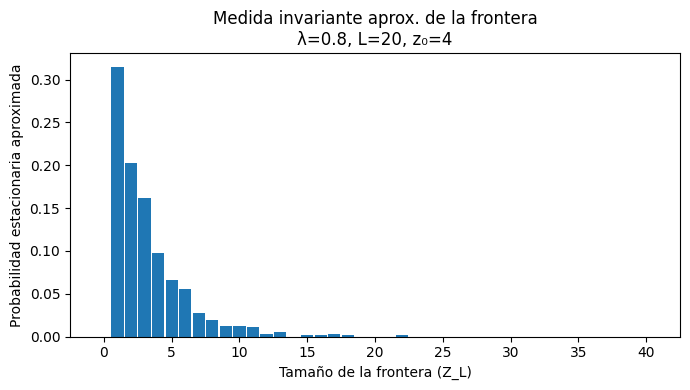

In [17]:
import matplotlib.pyplot as plt

# Parámetros del proceso miope
lam = 0.8
L = 20
z0 = 4
N_max = 600          # más grande → más pasos X_n
burn_in_steps = 100  # descartamos los primeros pasos
max_k_frontier = 40

results = simulate_invariant_via_tree(
    lam=lam,
    L=L,
    z0=z0,
    N_max=N_max,
    burn_in_steps=burn_in_steps,
    seed=123,
    max_k_frontier=max_k_frontier,
)

hist = results["hist_frontier"]        # ≈ π{Z_frontera = k}
support = results["support_frontier"]  # k = 0,1,...,max_k_frontier

print("Pasos brutos X_n:", results["n_raw_steps"])
print("Pasos tras burn-in:", results["n_eff_steps"])

# Esperanza estacionaria aproximada de la frontera
E_frontier = (support * hist).sum()
print(f"E[Z_frontera] ≈ {E_frontier:.3f}")

# --- Visualización ---
fig, ax = plt.subplots(figsize=(7, 4))
ax.bar(support, hist, width=0.9)
ax.set_xlabel("Tamaño de la frontera (Z_L)")
ax.set_ylabel("Probabilidad estacionaria aproximada")
ax.set_title(f"Medida invariante aprox. de la frontera\nλ={lam}, L={L}, z₀={z0}")
fig.tight_layout()
plt.show()


In [19]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# OJO: aquí se asume que simulate_myopic_GW_tree ya está definido
# más arriba en el mismo archivo, sin modificar su código.


def estimar_y_visualizar_medida_invariante(
    lam: float,
    L: int,
    z0: int = 1,
    N_max: int = 80,
    burn_in: int = 20,
    max_state: int = 20,
    seed: Optional[int] = None,
    show_plot: bool = True,
):
    """
    Aproxima y visualiza la medida invariante del tamaño de la generación en la
    frontera para el proceso de Galton–Watson miope, usando simulate_myopic_GW_tree.

    Parámetros
    ----------
    lam : float
        Parámetro de Poisson de la reproducción (λ).
    L : int
        Longitud de la ventana miope.
    z0 : int, opcional
        Tamaño inicial de la generación 0.
    N_max : int, opcional
        Cota superior en el índice de la generación de la frontera (parámetro que
        se pasa a simulate_myopic_GW_tree). Valores muy grandes pueden consumir
        mucha memoria, porque la función guarda copias del árbol en cada evento.
    burn_in : int, opcional
        Número de primeros eventos que se descartan para “quemar” la fase transitoria.
    max_state : int, opcional
        Último estado que se representa explícitamente en la gráfica; la masa en
        {k > max_state} se agrupa como cola.
    seed : int o None, opcional
        Semilla para reproducibilidad (si None, se usa una semilla aleatoria).
    show_plot : bool, opcional
        Si True, dibuja un histograma de la medida invariante empírica.

    Devuelve
    --------
    dist : dict[int, float]
        Aproximación empírica de la medida invariante: dist[k] ≈ μ(k) para k ≤ max_state.
    tail_mass : float
        Masa empírica en la cola: sum_{k > max_state} μ̂(k).
    total_muestras : int
        Número de observaciones usadas tras el burn-in.
    """

    # Generador aleatorio
    rng = np.random.default_rng(seed) if seed is not None else np.random.default_rng()

    # Simulación miope usando TU código original
    events = simulate_myopic_GW_tree(lam, L, z0=z0, N_max=N_max, rng=rng)

    # Tamaño de la generación en la frontera después de cada evento
    sizes = []
    for ev in events:
        frontier = ev["frontier_gen"]
        levels = ev["levels"]           # dict: generación -> lista de nodos
        sizes.append(len(levels.get(frontier, [])))

    if burn_in >= len(sizes):
        raise ValueError(
            f"burn_in = {burn_in} es demasiado grande; "
            f"solo hay {len(sizes)} eventos en la trayectoria."
        )

    # Descartamos los primeros 'burn_in' eventos (fase transitoria)
    data = sizes[burn_in:]

    # Frecuencias empíricas
    cnt = Counter(data)
    total = sum(cnt.values())

    dist = {}
    tail_mass = 0.0
    for k, v in cnt.items():
        p = v / total
        if k <= max_state:
            dist[k] = p
        else:
            tail_mass += p

    # Visualización de la distribución empírica
    if show_plot:
        xs = sorted(dist.keys())
        ps = [dist[x] for x in xs]

        plt.figure(figsize=(6, 4))
        plt.bar(xs, ps, align="center")
        plt.xlabel("Tamaño de la generación en la frontera")
        plt.ylabel("Frecuencia empírica")
        plt.title(f"Medida invariante empírica (λ={lam:.2f}, L={L}, N_max={N_max})")
        plt.tight_layout()
        plt.show()

        if tail_mass > 0:
            print(f"Masa empírica en estados > {max_state}: {tail_mass:.4f}")

    return dist, tail_mass, total


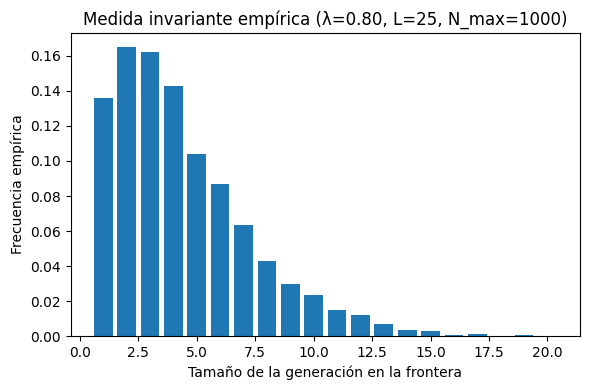

Masa empírica en estados > 20: 0.0006
Número de muestras usadas: 6884
Distribución empírica (hasta 20):
  k= 1 -> 0.1357
  k= 2 -> 0.1649
  k= 3 -> 0.1624
  k= 4 -> 0.1426
  k= 5 -> 0.1040
  k= 6 -> 0.0867
  k= 7 -> 0.0636
  k= 8 -> 0.0427
  k= 9 -> 0.0298
  k=10 -> 0.0234
  k=11 -> 0.0148
  k=12 -> 0.0121
  k=13 -> 0.0068
  k=14 -> 0.0035
  k=15 -> 0.0031
  k=16 -> 0.0007
  k=17 -> 0.0015
  k=18 -> 0.0003
  k=19 -> 0.0007
  k=20 -> 0.0001
Masa empírica en la cola: 0.0005810575246949448


In [19]:


dist, tail, total = estimar_y_visualizar_medida_invariante(
    lam=0.8,
    L=25,
    z0=1,
    N_max=1000,
    burn_in=20,
    max_state=20,
    seed=2023,
    show_plot=True,
)

print("Número de muestras usadas:", total)
print("Distribución empírica (hasta 20):")
for k in sorted(dist.keys()):
    print(f"  k={k:2d} -> {dist[k]:.4f}")
print("Masa empírica en la cola:", tail)


In [20]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Dict, List

# OJO: aquí se asume que simulate_myopic_GW_tree ya está definido
# más arriba en el mismo archivo, sin modificar su código.


def estimar_y_visualizar_medida_invariante(
    lam: float,
    L: int,
    z0: int = 1,
    N_max: int = 80,
    burn_in: int = 20,
    max_state: int = 20,
    seed: Optional[int] = None,
    show_plot: bool = True,
):
    """
    Opción B (eje de generaciones).

    Aproxima y visualiza la medida invariante del tamaño de una generación
    típica del árbol GW miope *resultante*, usando simulate_myopic_GW_tree.

    Procedimiento:
    - Se ejecuta simulate_myopic_GW_tree hasta que la frontera alcanza N_max.
    - Se toma el ÚLTIMO estado del árbol (último evento).
    - Se construye la sucesión de tamaños por generación
          Z_0, Z_1, ..., Z_T
      donde T es la generación frontera final.
    - Se descartan las primeras `burn_in` generaciones (para eliminar efectos
      de la condición inicial).
    - Sobre el resto se estiman las frecuencias empíricas de Z_n.

    Parámetros
    ----------
    lam : float
        Parámetro de Poisson de la reproducción (λ).
    L : int
        Longitud de la ventana miope.
    z0 : int, opcional
        Tamaño inicial de la generación 0.
    N_max : int, opcional
        Máximo índice de generación que se permite alcanzar en la simulación.
        Valores muy grandes pueden consumir mucha memoria, porque
        simulate_myopic_GW_tree almacena el árbol en cada evento.
    burn_in : int, opcional
        Número de primeras generaciones (en el eje de generaciones) que se
        descartan para “quemar” la fase transitoria.
    max_state : int, opcional
        Último tamaño que se representa explícitamente en la gráfica; la masa en
        {k > max_state} se agrupa en la cola.
    seed : int o None, opcional
        Semilla para reproducibilidad (si None, se usa una semilla aleatoria).
    show_plot : bool, opcional
        Si True, dibuja un histograma de la medida invariante empírica.

    Devuelve
    --------
    dist : dict[int, float]
        Aproximación empírica de la medida invariante espacial: dist[k] ≈ μ(k)
        para k ≤ max_state.
    tail_mass : float
        Masa empírica en la cola: sum_{k > max_state} μ̂(k).
    total_muestras : int
        Número de generaciones usadas tras el burn-in.
    """

    # Generador aleatorio
    rng = np.random.default_rng(seed) if seed is not None else np.random.default_rng()

    # 1) Simulación miope usando TU código original
    events = simulate_myopic_GW_tree(lam, L, z0=z0, N_max=N_max, rng=rng)

    if len(events) == 0:
        raise RuntimeError("simulate_myopic_GW_tree devolvió una lista vacía de eventos.")

    # 2) Árbol resultante = último estado almacenado
    last_event = events[-1]
    levels = last_event["levels"]           # dict: generación -> lista de nodos
    frontier_gen = last_event["frontier_gen"]

    # 3) Sucesión de tamaños por generación: Z_0, ..., Z_T
    sizes: List[int] = []
    for g in range(0, frontier_gen + 1):
        sizes.append(len(levels.get(g, [])))

    if burn_in >= len(sizes):
        raise ValueError(
            f"burn_in = {burn_in} es demasiado grande; "
            f"solo hay {len(sizes)} generaciones en el árbol final."
        )

    # 4) Descartamos las primeras 'burn_in' generaciones
    data = sizes[burn_in:]

    # 5) Frecuencias empíricas
    cnt = Counter(data)
    total = sum(cnt.values())

    dist: Dict[int, float] = {}
    tail_mass = 0.0
    for k, v in cnt.items():
        p = v / total
        if k <= max_state:
            dist[k] = p
        else:
            tail_mass += p

    # 6) Visualización de la distribución empírica
    if show_plot:
        xs = sorted(dist.keys())
        ps = [dist[x] for x in xs]

        plt.figure(figsize=(6, 4))
        plt.bar(xs, ps, align="center")
        plt.xlabel("Tamaño de la generación X_n (eje de generaciones)")
        plt.ylabel("Frecuencia empírica")
        plt.title(f"Medida invariante espacial empírica (λ={lam:.2f}, L={L}, N_max={N_max})")
        plt.tight_layout()
        plt.show()

        if tail_mass > 0:
            print(f"Masa empírica en estados > {max_state}: {tail_mass:.4f}")

    return dist, tail_mass, total


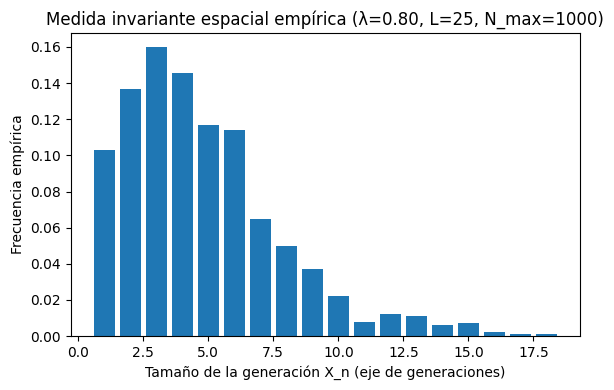

Masa empírica en estados > 20: 0.0020


In [21]:

# Parámetros del proceso
lam = 0.8      # parámetro de Poisson
L = 25          # longitud de la ventana miope
z0 = 5          # tamaño inicial
N_max = 1000    # profundidad máxima del árbol (generaciones)
burn_in = 0   # cuántas generaciones iniciales descartar
max_state = 20  # último tamaño a mostrar explícitamente en el histograma

# Semilla para reproducibilidad (puedes cambiarla o poner None)
seed = 2023

# Llamada: esto dibuja automáticamente el histograma
dist, tail_mass, total = estimar_y_visualizar_medida_invariante(
    lam=lam,
    L=L,
    z0=z0,
    N_max=N_max,
    burn_in=burn_in,
    max_state=max_state,
    seed=seed,
    show_plot=True,
)

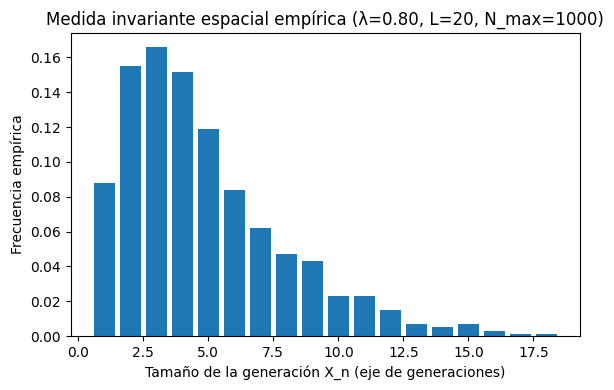

In [22]:
lam = 0.8      # parámetro de Poisson
L = 20          # longitud de la ventana miope
z0 = 5          # tamaño inicial
N_max = 1000    # profundidad máxima del árbol (generaciones)
burn_in = 0   # cuántas generaciones iniciales descartar
max_state = 20  # último tamaño a mostrar explícitamente en el histograma

# Semilla para reproducibilidad (puedes cambiarla o poner None)
seed = 2023

# Llamada: esto dibuja automáticamente el histograma
dist, tail_mass, total = estimar_y_visualizar_medida_invariante(
    lam=lam,
    L=L,
    z0=z0,
    N_max=N_max,
    burn_in=burn_in,
    max_state=max_state,
    seed=seed,
    show_plot=True,
)

In [23]:
import numpy as np

def ajustar_alpha_exponencial(dist: dict[int, float], k_min: int = 5):
    """
    Ajusta un modelo de cola exponencial
        μ(k) ≈ C * exp(-k/α)
    a partir de la medida invariante empírica dist[k] ≈ μ(k).

    Parámetros
    ----------
    dist : dict[int,float]
        Distribución empírica μ̂(k) (por ejemplo la devuelta por
        estimar_y_visualizar_medida_invariante, opción B).
    k_min : int
        Umbral a partir del cual se considera la 'cola' para el ajuste.

    Devuelve
    --------
    alpha_hat : float
        Estimación del parámetro de escala de la cola α.
        Cuanto mayor α, más gruesa la cola.
    slope : float
        Pendiente de la recta ajustada en el gráfico log μ(k) vs k.
        slope ≈ -1/α.
    intercept : float
        Término independiente de la recta.
    """
    # puntos de la cola con probabilidad positiva
    ks = np.array([k for k, p in dist.items() if k >= k_min and p > 0.0], dtype=float)
    if len(ks) < 2:
        # Demasiados pocos puntos en la cola para ajustar una recta
        return np.nan, np.nan, np.nan

    ps = np.array([dist[int(k)] for k in ks], dtype=float)
    logp = np.log(ps)

    # Ajuste lineal log μ(k) ≈ a + b k
    slope, intercept = np.polyfit(ks, logp, 1)

    # α ≈ -1/slope si la pendiente es negativa
    alpha_hat = -1.0 / slope if slope < 0 else np.nan
    return alpha_hat, slope, intercept


In [24]:

# Parámetros fijos
lam = 0.80
z0 = 1
N_max = 1000
burn_in = 200
max_state = 40
seed = 2023

# Valores de L que quieres explorar
L_values = [5, 10, 15, 20, 25,40]

alphas = {}

for L in L_values:
    # NO dibujamos histograma aquí (show_plot=False) para no saturar la salida
    dist, tail_mass, total = estimar_y_visualizar_medida_invariante(
        lam=lam,
        L=L,
        z0=z0,
        N_max=N_max,
        burn_in=burn_in,
        max_state=max_state,
        seed=seed,
        show_plot=False,
    )

    alpha_hat, slope, intercept = ajustar_alpha_exponencial(dist, k_min=5)
    alphas[L] = alpha_hat

    # Como estadística más grosera, también puedes mirar la masa en la cola
    prob_geq_10 = sum(p for k, p in dist.items() if k >= 10)
    if max_state >= 10:
        prob_geq_10 += tail_mass

    print(f"L={L:2d}: alpha_hat≈{alpha_hat:.3f},  P(Z≥10)≈{prob_geq_10:.3f}")

# Si quieres ver α(L) como tabla
print("\nResumen α(L):")
for L in L_values:
    print(f"L={L:2d} → α̂(L) ≈ {alphas[L]:.3f}")

L= 5: alpha_hat≈2.016,  P(Z≥10)≈0.024
L=10: alpha_hat≈2.628,  P(Z≥10)≈0.059
L=15: alpha_hat≈3.910,  P(Z≥10)≈0.099
L=20: alpha_hat≈2.821,  P(Z≥10)≈0.080
L=25: alpha_hat≈3.920,  P(Z≥10)≈0.069


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from myopic_gw_tree_multiroot import simulate_myopic_GW_tree


# ---------------------------
# 1. Helpers de medida
# ---------------------------

def extraer_tamanos_generaciones_desde_events(events):
    """
    Toma la lista de 'events' de simulate_myopic_GW_tree y devuelve el vector
    de tamaños por generación del árbol final: [Z_0, ..., Z_T].
    """
    last_event = events[-1]
    levels = last_event["levels"]          # dict: gen -> lista de nodos
    frontier_gen = last_event["frontier_gen"]
    sizes = [len(levels.get(g, [])) for g in range(frontier_gen + 1)]
    return np.array(sizes, dtype=int)


def distribucion_empirica(data, max_state):
    """
    A partir de una lista/array de tamaños de generación (positivos),
    devuelve (dist, tail), donde:
      - dist[k] es la frecuencia empírica de k para 1 <= k <= max_state,
      - tail es la masa acumulada en k > max_state.
    """
    cnt = Counter(data)
    total = len(data)
    dist = {}
    tail = 0.0
    for k, v in cnt.items():
        p = v / total
        if k <= max_state:
            dist[k] = p
        else:
            tail += p
    return dist, tail


def distancia_variacion_total(dist1, tail1, dist2, tail2, max_state):
    """
    Distancia de variación total entre dos medidas discretas
    truncadas en {1,...,max_state} con cola agregada.
    """
    s = 0.0
    for k in range(1, max_state + 1):
        s += abs(dist1.get(k, 0.0) - dist2.get(k, 0.0))
    s += abs(tail1 - tail2)
    return 0.5 * s


# -----------------------------------------------------------
# 2. Gráfico de convergencia a la medida invariante
# -----------------------------------------------------------

def graficar_convergencia_medida_invariante(
    lam: float,
    L: int,
    z0: int = 1,
    N_max: int = 2000,
    burn_in_generations: int = 200,
    max_state: int = 25,
    n_puntos: int = 50,
    seeds = (2025, 2026),
):
    """
    Estudia la convergencia a la medida invariante mediante un gráfico de
    distancia entre medidas empíricas.

    Para cada semilla en 'seeds':
      1. Simula un árbol miope hasta N_max con simulate_myopic_GW_tree.
      2. Extrae los tamaños por generación Z_0,...,Z_T del árbol final.
      3. Descarta las primeras 'burn_in_generations' generaciones.
      4. Calcula la medida empírica 'de referencia' μ̂_ref usando todas las
         generaciones restantes.
      5. Para una rejilla de n = n_1,...,n_m (longitudes de prefijo),
         calcula μ̂_n con los primeros n tamaños y la distancia L^1
         d_n = || μ̂_n - μ̂_ref ||_1.
      6. Dibuja d_n vs n para cada semilla (línea continua y discontinua).

    El decaimiento de d_n hacia 0 ilustra la convergencia a la medida invariante.
    """
    all_sizes = []

    # Simulamos una trayectoria de tamaños por generación para cada semilla
    for seed in seeds:
        rng = np.random.default_rng(seed)
        events = simulate_myopic_GW_tree(
            lam=lam,
            L=L,
            z0=z0,
            N_max=N_max,
            rng=rng,
        )
        sizes = extraer_tamanos_generaciones_desde_events(events)
        if burn_in_generations >= len(sizes):
            raise ValueError(
                f"burn_in_generations={burn_in_generations} es demasiado grande; "
                f"el árbol sólo tiene {len(sizes)} generaciones."
            )
        sizes_eff = sizes[burn_in_generations:]  # “interior” del árbol
        all_sizes.append(sizes_eff)

    # Usaremos una rejilla de n común a todas las trayectorias
    T_min = min(len(s) for s in all_sizes)
    ns = np.linspace(20, T_min, n_puntos, dtype=int)  # empezamos en 20 para evitar n muy pequeños

    plt.figure(figsize=(6, 4))

    estilos = ["-", "--", "-.", ":"]
    for idx, sizes_eff in enumerate(all_sizes):
        # Medida empírica de referencia (usando TODA la trayectoria tras el burn-in)
        dist_ref, tail_ref = distribucion_empirica(sizes_eff, max_state=max_state)

        d_vals = []
        for n in ns:
            dist_n, tail_n = distribucion_empirica(sizes_eff[:n], max_state=max_state)
            d = distancia_variacion_total(dist_n, tail_n, dist_ref, tail_ref, max_state)
            d_vals.append(d)

        estilo = estilos[idx % len(estilos)]
        plt.plot(ns, d_vals, estilo, label=f"semilla {seeds[idx]}")

    plt.xlabel("n (longitud del prefijo en generaciones)")
    plt.ylabel(r"distancia en variación total")
    plt.title(f"Convergencia empírica a la medida invariante (λ={lam:.2f}, L={L})")
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------------------------------
# 3. Ejemplo de uso
# -----------------------------------------------

graficar_convergencia_medida_invariante(
    lam=0.80,
    L=40,
    z0=1,
    N_max=1000,              # puedes subirlo si el tiempo lo permite
    burn_in_generations=0,
    max_state=25,
    n_puntos=80,
    seeds=(2025, 2026),
)


In [ ]:


import numpy as np
import matplotlib.pyplot as plt


# Se asume que ajustar_alpha_exponencial(dist, k_min) ya está definida en tu notebook


# -------------------------------
# Parámetros básicos de simulación
# -------------------------------
lam = 0.80
z0 = 1

# OJO: ajusta estos si quieres más precisión / menos tiempo
N_max = 1200       # profundidad máxima del árbol (eje de generaciones)
burn_in = 200      # generaciones iniciales que descartas
max_state = 40     # máximo tamaño explícito en dist[k]
k_min_tail = 5     # a partir de qué k empiezas a ajustar la cola

# Valores de L: muy densos al principio, luego más espaciados
L_values = list(range(2, 16)) + [18, 20, 22, 25, 30, 35, 40]

num_runs = 3       # nº de simulaciones por cada L (sube si quieres más suavidad)

rng_master = np.random.default_rng(2025)

alphas_mean = []
alphas_std = []

print("Estimando α(L) para distintos valores de L:\n")

for L in L_values:
    alpha_runs = []
    print(f"L = {L:2d}:", end=" ")
    for r in range(num_runs):
        seed = int(rng_master.integers(0, 10**9))

        dist, tail_mass, total = estimar_y_visualizar_medida_invariante(
            lam=lam,
            L=L,
            z0=z0,
            N_max=N_max,
            burn_in=burn_in,
            max_state=max_state,
            seed=seed,
            show_plot=False,     # no dibujamos histograma de μ̂ en cada simulación
        )

        alpha_hat, slope, intercept = ajustar_alpha_exponencial(dist, k_min=k_min_tail)
        alpha_runs.append(alpha_hat)
        print(f"{alpha_hat:.3f}", end="  ")

    alpha_runs = np.array(alpha_runs, dtype=float)
    alphas_mean.append(alpha_runs.mean())
    alphas_std.append(alpha_runs.std(ddof=1))
    print()

alphas_mean = np.array(alphas_mean)
alphas_std  = np.array(alphas_std)
L_arr       = np.array(L_values, dtype=float)

# -------------------------------
# Gráfico α(L) estilo "curva suave"
# -------------------------------
plt.figure(figsize=(6, 4))
plt.plot(L_arr, alphas_mean, "-o", label=r"media de $\hat{\alpha}(L)$")
plt.fill_between(
    L_arr,
    alphas_mean - alphas_std,
    alphas_mean + alphas_std,
    alpha=0.2,
    label=r"± 1 desvío estándar"
)
plt.xlabel("L")
plt.ylabel(r"$\hat{\alpha}(L)$")
plt.title(r"Estimación de $\alpha(L)$ en función de L (λ = %.2f)" % lam)
plt.legend()
plt.tight_layout()
plt.show()

# Tabla resumida en texto
print("\nResumen de α̂(L):")
for L, m, s in zip(L_values, alphas_mean, alphas_std):
    print(f"L={L:2d}: media ≈ {m:.3f}, desvío ≈ {s:.3f}")


In [ ]:
def extraer_tamanos_generaciones_desde_events(events):
    """
    Toma la lista de 'events' que devuelve simulate_myopic_GW_tree
    y construye el vector de tamaños por generación del árbol final:

        sizes = [Z_0, Z_1, ..., Z_T].

    Aquí T = frontier_gen del último evento.
    """
    last_event = events[-1]
    levels = last_event["levels"]          # dict: gen -> lista de nodos
    frontier_gen = last_event["frontier_gen"]
    sizes = [len(levels.get(g, [])) for g in range(frontier_gen + 1)]
    return np.array(sizes, dtype=float)


# --- Autocorrelación empírica de una serie unidimensional ---

def autocorrelacion_empirica(x: np.ndarray, max_lag: int):
    """
    Calcula la autocorrelación empírica ρ̂(k) para k=0,...,max_lag.

    Normaliza de forma que ρ̂(0)=1.
    """
    x = np.asarray(x, dtype=float)
    x = x - x.mean()
    n = len(x)
    var = np.dot(x, x) / n
    if var == 0:
        return np.ones(max_lag + 1)

    max_lag = min(max_lag, n - 1)
    r = np.empty(max_lag + 1)
    r[0] = 1.0
    for k in range(1, max_lag + 1):
        r[k] = np.dot(x[:-k], x[k:]) / ((n - k) * var)
    return r


# --- Medidas empíricas y distancia en variación total (truncada) ---

def distribucion_empirica(data, max_state: int):
    """
    A partir de una lista/array de tamaños de generación (positivos),
    devuelve (dist, tail), donde:
      - dist[k] es la frecuencia empírica de k para 1 ≤ k ≤ max_state,
      - tail es la masa acumulada en k > max_state.
    """
    cnt = Counter(data)
    total = len(data)
    dist = {}
    tail = 0.0
    for k, v in cnt.items():
        p = v / total
        if k <= max_state:
            dist[k] = p
        else:
            tail += p
    return dist, tail


def distancia_TV(dist1, tail1, dist2, tail2, max_state: int):
    """
    Distancia en variación total entre dos medidas discretas truncadas
    en {1,...,max_state} con cola agregada.
    """
    s = 0.0
    for k in range(1, max_state + 1):
        s += abs(dist1.get(k, 0.0) - dist2.get(k, 0.0))
    s += abs(tail1 - tail2)
    return 0.5 * s
def estimar_tiempo_relajacion(
    lam: float,
    L: int,
    z0: int = 1,
    N_max: int = 2000,
    burn_in_generations: int = 200,
    max_lag: int = 200,
    seed: int | None = None,
):
    """
    Estima un tiempo de relajación τ_int(L) a partir de la autocorrelación
    de los tamaños de generación en el eje espacial (opción B).

    Procedimiento:
    - Simula un árbol miope con simulate_myopic_GW_tree.
    - Extrae Z_0,...,Z_T y descarta las primeras 'burn_in_generations'.
    - Calcula la autocorrelación empírica ρ̂(k), k=0,...,max_lag.
    - Define la "autocorrelación integrada"
          τ_int = 1 + 2 * sum_{k>=1, ρ̂(k)>0} ρ̂(k)
      cortando en el primer lag donde ρ̂(k) ≤ 0 o en max_lag.

    Devuelve
    --------
    tau_int : float
        Estimación del tiempo de relajación en unidades de "generaciones".
    rho : np.ndarray
        Vector ρ̂(k) para k=0,...,K, donde K es el max_lag efectivo utilizado.
    """
    rng = np.random.default_rng(seed)
    events = simulate_myopic_GW_tree(lam=lam, L=L, z0=z0, N_max=N_max, rng=rng)
    sizes = extraer_tamanos_generaciones_desde_events(events)

    if burn_in_generations >= len(sizes):
        raise ValueError(
            f"burn_in_generations={burn_in_generations} es demasiado grande; "
            f"el árbol sólo tiene {len(sizes)} generaciones."
        )

    data = sizes[burn_in_generations:]
    max_lag = min(max_lag, len(data)//2)
    rho = autocorrelacion_empirica(data, max_lag)

    # cortamos la suma en el primer lag donde la autocorrelación se hace ≤ 0
    cutoff = max_lag
    for k in range(1, max_lag + 1):
        if rho[k] <= 0:
            cutoff = k - 1
            break

    if cutoff == 0:
        tau_int = 1.0
    else:
        tau_int = 1.0 + 2.0 * rho[1:cutoff+1].sum()

    return tau_int, rho[:cutoff+1]


def estimar_tiempo_mezcla(
    lam: float,
    L: int,
    z0: int = 1,
    N_max: int = 2000,
    burn_in_generations: int = 200,
    max_state: int = 25,
    eps: float = 0.05,
    n_puntos: int = 80,
    seed: int | None = None,
):
    """
    Estima un tiempo de mezcla t_mix(L, eps) en variación total.

    Procedimiento:
    - Simula un árbol miope con simulate_myopic_GW_tree.
    - Extrae Z_0,...,Z_T y descarta las primeras 'burn_in_generations'.
    - Construye la medida empírica de referencia μ̂_ref con TODAS
      las generaciones restantes.
    - Para una rejilla de tamaños de prefijo n_1 < ... < n_m:
        * calcula μ̂_n usando sólo las primeras n generaciones,
        * calcula d(n) = TV( μ̂_n, μ̂_ref ).
    - Define t_mix como el primer n de la rejilla con d(n) <= eps.

    Devuelve
    --------
    ns : np.ndarray
        Rejilla de tamaños de prefijo.
    d_vals : np.ndarray
        Distancias en variación total d(n) en la rejilla.
    t_mix : int | None
        Estimación de t_mix(L, eps) si se alcanza; None si no se cumple d(n)<=eps.
    """
    rng = np.random.default_rng(seed)
    events = simulate_myopic_GW_tree(lam=lam, L=L, z0=z0, N_max=N_max, rng=rng)
    sizes = extraer_tamanos_generaciones_desde_events(events)

    if burn_in_generations >= len(sizes):
        raise ValueError(
            f"burn_in_generations={burn_in_generations} es demasiado grande; "
            f"el árbol sólo tiene {len(sizes)} generaciones."
        )

    data = sizes[burn_in_generations:]
    T = len(data)

    dist_ref, tail_ref = distribucion_empirica(data, max_state=max_state)

    # rejilla de n: empezamos en 20 para evitar tamaños ridículamente pequeños
    ns = np.linspace(20, T, n_puntos, dtype=int)
    d_vals = []
    t_mix = None

    for n in ns:
        dist_n, tail_n = distribucion_empirica(data[:n], max_state=max_state)
        d = distancia_TV(dist_n, tail_n, dist_ref, tail_ref, max_state=max_state)
        d_vals.append(d)
        if t_mix is None and d <= eps:
            t_mix = n

    return ns, np.array(d_vals), t_mix


In [18]:
# Parámetros del proceso
lam = 0.80
z0 = 1

# OJO: ajusta N_max y burn_in_generations si quieres más precisión / menos tiempo
N_max = 2000
burn_in_generations = 0
max_state = 25
eps = 0.05      # umbral de mezcla en TV

# Valores de L: más densos cuando L es pequeño, hasta 40
L_values = list(range(2, 16)) + [18, 20, 25, 30, 35, 40]

num_runs = 4    # número de simulaciones por L para promediar
rng_master = np.random.default_rng(2025)

tau_means = []
tau_stds = []
tmix_means = []
tmix_stds = []

print("Estimando tiempos de relajación y mezcla:\n")

for L in L_values:
    taus = []
    tmixs = []
    print(f"L={L:2d}:", end=" ")
    for r in range(num_runs):
        seed = int(rng_master.integers(0, 10**9))

        # tiempo de relajación (τ_int)
        tau_int, rho = estimar_tiempo_relajacion(
            lam=lam,
            L=L,
            z0=z0,
            N_max=N_max,
            burn_in_generations=burn_in_generations,
            max_lag=200,
            seed=seed,
        )

        # tiempo de mezcla (TV <= eps)
        ns, d_vals, t_mix = estimar_tiempo_mezcla(
            lam=lam,
            L=L,
            z0=z0,
            N_max=N_max,
            burn_in_generations=burn_in_generations,
            max_state=max_state,
            eps=eps,
            n_puntos=60,
            seed=seed + 1,   # semilla distinta, pero correlacionada
        )

        taus.append(tau_int)
        # si t_mix nunca baja de eps, lo marcamos como NaN para no romper la media
        tmixs.append(np.nan if t_mix is None else t_mix)

        print(f"τ_int≈{tau_int:6.1f}, t_mix≈{t_mix if t_mix is not None else -1:4d}", end="  ")

    print()
    taus = np.array(taus, dtype=float)
    tmixs = np.array(tmixs, dtype=float)

    tau_means.append(np.nanmean(taus))
    tau_stds.append(np.nanstd(taus, ddof=1))

    tmix_means.append(np.nanmean(tmixs))
    tmix_stds.append(np.nanstd(tmixs, ddof=1))

L_arr = np.array(L_values, dtype=float)
tau_means = np.array(tau_means)
tau_stds  = np.array(tau_stds)
tmix_means = np.array(tmix_means)
tmix_stds  = np.array(tmix_stds)


# --- Gráfico: tiempo de relajación vs L ---
plt.figure(figsize=(6, 4))
plt.errorbar(L_arr, tau_means, yerr=tau_stds, fmt='o-', capsize=3)
plt.xlabel("L")
plt.ylabel(r"τ_int(L)  (tiempo de relajación)")
plt.title(r"Tiempo de relajación estimado en función de L (λ=%.2f)" % lam)
plt.tight_layout()
plt.show()


# --- Gráfico: tiempo de mezcla vs L ---
plt.figure(figsize=(6, 4))
plt.errorbar(L_arr, tmix_means, yerr=tmix_stds, fmt='o-', capsize=3)
plt.xlabel("L")
plt.ylabel(r"$t_{\mathrm{mix}}(L,\varepsilon)$ con $\varepsilon=%.2f$" % eps)
plt.title(r"Tiempo de mezcla estimado en función de L (λ=%.2f)" % lam)
plt.tight_layout()
plt.show()

print("\nResumen numérico (λ=%.2f, eps=%.2f):" % (lam, eps))
for L, m_tau, s_tau, m_mix, s_mix in zip(L_values, tau_means, tau_stds, tmix_means, tmix_stds):
    print(f"L={L:2d}:  τ_int≈{m_tau:7.2f} ± {s_tau:5.2f},  "
          f"t_mix≈{m_mix:7.1f} ± {s_mix:5.1f}")


Estimando tiempos de relajación y mezcla:

L= 2: 

NameError: name 'estimar_tiempo_relajacion' is not defined

In [17]:
# ---------------------------------------------------------
# 1. Cadena de Markov en tiempo de algoritmo: Y_n
#    (tamaño de la frontera después de cada evento)
# ---------------------------------------------------------

def extraer_cadena_Y_desde_events(events):
    """
    De la lista de 'events' de simulate_myopic_GW_tree devuelve
    la cadena Y_n = tamaño de la frontera en cada evento.

    Y_n = |levels[frontier_gen]|.
    """
    sizes = []
    for ev in events:
        frontier = ev["frontier_gen"]
        levels = ev["levels"]          # dict: gen -> lista de nodos
        sizes.append(len(levels.get(frontier, [])))
    return np.array(sizes, dtype=int)


# ---------------------------------------------------------
# 2. Medida invariante aproximada de Y_n
# ---------------------------------------------------------

def estimar_medida_invariante_Y(
    lam: float,
    L: int,
    z0: int = 1,
    N_max: int = 5000,
    burn_in_steps: int = 1000,
    max_state: int = 40,
    seed: int | None = None,
):
    """
    Aproxima la medida invariante μ de la cadena (Y_n) usando
    una sola trayectoria larga iniciada en z0.

    μ̂(k) = frecuencia empírica de Y_n = k para n >= burn_in_steps.
    La masa en k > max_state se agrupa en 'tail'.
    """
    rng = np.random.default_rng(seed)
    events = simulate_myopic_GW_tree(lam=lam, L=L, z0=z0, N_max=N_max, rng=rng)
    Y = extraer_cadena_Y_desde_events(events)

    if burn_in_steps >= len(Y):
        raise ValueError(
            f"burn_in_steps={burn_in_steps} es demasiado grande; "
            f"la trayectoria tiene sólo {len(Y)} pasos."
        )

    data = Y[burn_in_steps:]
    cnt = Counter(data)
    total = len(data)

    mu = {}
    tail = 0.0
    for k, v in cnt.items():
        p = v / total
        if k <= max_state:
            mu[k] = p
        else:
            tail += p

    return mu, tail


# ---------------------------------------------------------
# 3. Distancia en variación total entre dos medidas truncadas
# ---------------------------------------------------------

def distancia_TV_trunc(mu1: dict[int,float], tail1: float,
                       mu2: dict[int,float], tail2: float,
                       max_state: int) -> float:
    s = 0.0
    for k in range(1, max_state+1):
        s += abs(mu1.get(k, 0.0) - mu2.get(k, 0.0))
    s += abs(tail1 - tail2)
    return 0.5 * s


# ---------------------------------------------------------
# 4. Aproximación de D_n = sup_x ||P^n(x,·) - μ||_TV
# ---------------------------------------------------------

def estimar_Dn_para_L(
    lam: float,
    L: int,
    mu: dict[int,float],
    mu_tail: float,
    max_state: int = 40,
    n_max: int = 80,
    n_grid: int = 40,
    inits: list[int] | None = None,
    n_traj_por_init: int = 200,
    N_max_traj: int | None = None,
    seed: int | None = None,
):
    """
    Versión optimizada: reusa trayectorias largas para todos los n.

    - Para cada estado inicial x0:
        * Genera n_traj_por_init trayectorias Y^{(r)}_0,...,Y^{(r)}_{N_max_traj}.
    - Para cada n de la rejilla:
        * Para cada x0, construye la ley empírica de Y^{(r)}_n
          reutilizando las mismas trayectorias.
        * Calcula TV( P^n(x0,·), μ ).
        * Toma el máximo sobre x0 → D_n.

    Así el nº de llamadas a simulate_myopic_GW_tree es
        len(inits) * n_traj_por_init
    en lugar de
        len(inits) * n_traj_por_init * len(ns).
    """
    if inits is None:
        inits = [1, 2, 3, 5, 8]

    if N_max_traj is None:
        N_max_traj = 10 * n_max

    rng_master = np.random.default_rng(seed)

    # Rejilla de tiempos n
    ns = np.linspace(1, n_max, n_grid, dtype=int)
    ns = np.unique(ns)
    n_max_grid = int(ns.max())

    # Para cada x0 guardaremos todas las muestras Y_n^{(r)} para todos los n de la rejilla
    # Estructura: muestras[x0][i] = lista de valores Y_{n_i} sobre las trayectorias r
    muestras_por_x0 = {x0: {n: [] for n in ns} for x0 in inits}

    # 1) Simulaciones: para cada x0 y cada trayectoria, llenamos todas las Y_{n}
    for x0 in inits:
        for r in range(n_traj_por_init):
            seed_r = int(rng_master.integers(0, 10**9))
            rng = np.random.default_rng(seed_r)

            events = simulate_myopic_GW_tree(
                lam=lam, L=L, z0=x0, N_max=N_max_traj, rng=rng
            )
            Y = extraer_cadena_Y_desde_events(events)

            if len(Y) <= n_max_grid:
                raise RuntimeError(
                    f"La trayectoria desde x0={x0} tiene sólo {len(Y)} pasos, "
                    f"pero se requiere n_max_grid={n_max_grid}. Aumenta N_max_traj."
                )

            for n in ns:
                muestras_por_x0[x0][int(n)].append(int(Y[n]))

    # 2) Para cada n, calculamos D_n = sup_x0 TV( P^n(x0,·), μ )
    D_vals = []
    for n in ns:
        D_n_est = 0.0
        for x0 in inits:
            muestras = muestras_por_x0[x0][int(n)]
            cnt = Counter(muestras)
            total = len(muestras)

            nu = {}
            nu_tail = 0.0
            for k, v in cnt.items():
                p = v / total
                if k <= max_state:
                    nu[k] = p
                else:
                    nu_tail += p

            tv = distancia_TV_trunc(nu, nu_tail, mu, mu_tail, max_state)
            if tv > D_n_est:
                D_n_est = tv

        D_vals.append(D_n_est)

    return ns, np.array(D_vals)



# ---------------------------------------------------------
# 5. A partir de D_n: t_rel y t_mix(ε)
# ---------------------------------------------------------

def estimar_tiempos_desde_Dn(ns: np.ndarray, D_vals: np.ndarray,
                             eps: float = 0.05, frac_tail: float = 0.5):
    """
    A partir de una serie (ns, D_n) aproxima:

      - tiempo de relajación t_rel ≈ -1/slope en log D_n vs n
        usando sólo la 'cola' (última fracción frac_tail de puntos).
      - tiempo de mezcla t_mix(ε) = min { n : D_n <= ε } (si existe).

    Devuelve (t_rel_hat, t_mix_hat).
    """
    # t_mix(ε)
    t_mix_hat = None
    for n, Dn in zip(ns, D_vals):
        if Dn <= eps:
            t_mix_hat = int(n)
            break

    # t_rel: ajuste lineal en la cola
    m = len(ns)
    m_tail = max(3, int(frac_tail * m))
    ns_tail = ns[-m_tail:]
    D_tail = D_vals[-m_tail:]

    # Evitamos log(0)
    D_tail_clipped = np.clip(D_tail, 1e-12, 1.0)
    logD = np.log(D_tail_clipped)

    slope, intercept = np.polyfit(ns_tail, logD, 1)
    t_rel_hat = -1.0 / slope if slope < 0 else np.inf

    return t_rel_hat, t_mix_hat, (ns_tail, logD, slope, intercept)


Medida invariante empírica de Y_n (truncada):
  μ̂(1) ≈ 0.1676
  μ̂(2) ≈ 0.1909
  μ̂(3) ≈ 0.1636
  μ̂(4) ≈ 0.1347
  μ̂(5) ≈ 0.1032
  μ̂(6) ≈ 0.0717
  μ̂(7) ≈ 0.0522
  μ̂(8) ≈ 0.0363
  μ̂(9) ≈ 0.0252
  μ̂(10) ≈ 0.0173
  μ̂(11) ≈ 0.0134
  μ̂(12) ≈ 0.0092
  μ̂(13) ≈ 0.0054
  μ̂(14) ≈ 0.0038
  μ̂(15) ≈ 0.0020
  μ̂(16) ≈ 0.0012
  μ̂(17) ≈ 0.0008
  μ̂(18) ≈ 0.0006
  μ̂(19) ≈ 0.0002
  μ̂(20) ≈ 0.0001
  μ̂(21) ≈ 0.0003
  μ̂(25) ≈ 0.0000
  Cola k>40: 0.0000

Estimación espectral (profesor):
  t_rel ≈ 899.15
  t_mix(0.05) ≈ no alcanzado



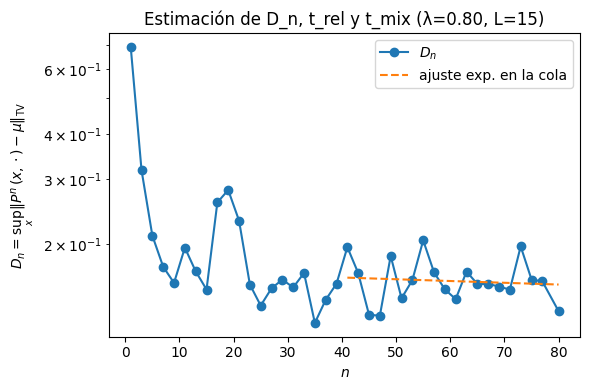

In [32]:
# Parámetros del proceso
lam = 0.80
L   = 15

# Parámetros para estimar μ (invariante de Y_n)
N_max_mu      = 4000
burn_in_steps = 10
max_state     = 40

# Parámetros para D_n (mucho más ligeros)
n_max           = 80    # antes 80
n_grid          = 40    # antes 40
inits           = [1, 3, 5]   # antes [1,2,3,5,8]
n_traj_por_init = 100    # antes 200
N_max_traj      = 1000   # antes 10 * n_max (= 800)

eps=0.05


# 1. Medida invariante aproximada μ̂ de Y_n
mu_hat, mu_tail_hat = estimar_medida_invariante_Y(
    lam=lam,
    L=L,
    z0=1,
    N_max=N_max_mu,
    burn_in_steps=burn_in_steps,
    max_state=max_state,
    seed=2025,
)

print("Medida invariante empírica de Y_n (truncada):")
for k in sorted(mu_hat.keys()):
    print(f"  μ̂({k}) ≈ {mu_hat[k]:.4f}")
print(f"  Cola k>{max_state}: {mu_tail_hat:.4f}\n")


# 2. Serie D_n para n en una rejilla
ns, D_vals = estimar_Dn_para_L(
    lam=lam,
    L=L,
    mu=mu_hat,
    mu_tail=mu_tail_hat,
    max_state=max_state,
    n_max=n_max,
    n_grid=n_grid,
    inits=inits,
    n_traj_por_init=n_traj_por_init,
    N_max_traj=N_max_traj,
    seed=1234,
)



# 3. Estimación de t_rel y t_mix(ε) a partir de D_n
t_rel_hat, t_mix_hat, (ns_tail, logD_tail, slope, intercept) = \
    estimar_tiempos_desde_Dn(ns, D_vals, eps=eps, frac_tail=0.5)

print(f"Estimación espectral (profesor):")
print(f"  t_rel ≈ {t_rel_hat:.2f}")
print(f"  t_mix({eps}) ≈ {t_mix_hat if t_mix_hat is not None else 'no alcanzado'}\n")


# 4. Gráfico de D_n en escala log, con recta ajustada en la cola
plt.figure(figsize=(6,4))
plt.plot(ns, D_vals, 'o-', label=r'$D_n$')
# recta ajustada en la cola
fit_line = np.exp(intercept + slope * ns_tail)
plt.plot(ns_tail, fit_line, '--', label='ajuste exp. en la cola')

plt.yscale('log')
plt.xlabel(r'$n$')
plt.ylabel(r'$D_n = \sup_x \|P^n(x,\cdot)-\mu\|_{\mathrm{TV}}$')
plt.title(f"Estimación de D_n, t_rel y t_mix (λ={lam:.2f}, L={L})")
plt.legend()
plt.tight_layout()
plt.show()


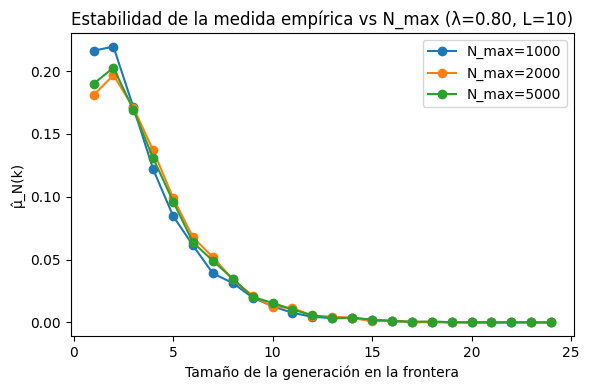

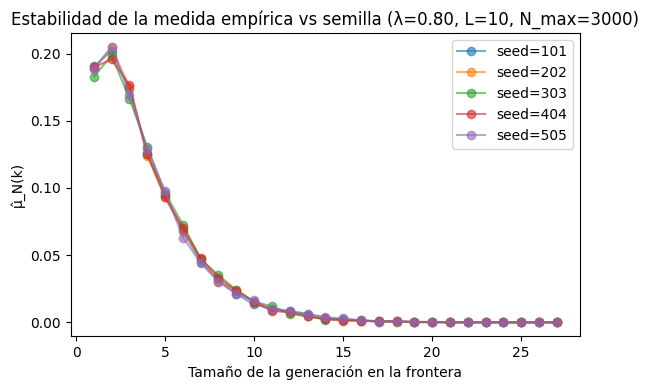

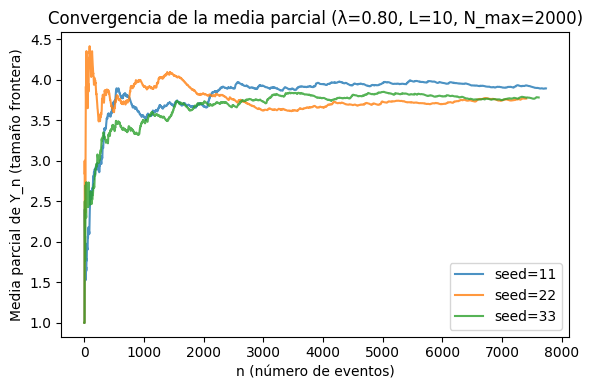

In [20]:
# ============================================================================
# 1. Estabilidad de la medida empírica frente a N_max
# ============================================================================

def estabilidad_vs_Nmax(
    lam: float,
    L: int,
    N_max_list,
    z0: int = 1,
    burn_in: int = 200,
    max_state: int = 40,
    base_seed: int = 1234,
):
    """
    Compara las medidas empíricas μ̂ obtenidas para distintos N_max, fijando (λ,L).

    Para cada N_max:
      - llama a estimar_y_visualizar_medida_invariante con show_plot=False,
      - guarda la distribución dist[k],
      - dibuja curvas p(k) vs k superpuestas.

    Permite ver cuándo los histogramas dejan de cambiar de forma apreciable
    al aumentar N_max.
    """
    N_max_list = list(N_max_list)
    results = {}
    all_ks = set()

    for j, N_max in enumerate(N_max_list):
        seed = base_seed + j  # puedes fijar siempre la misma semilla si prefieres
        dist, tail, total = estimar_y_visualizar_medida_invariante(
            lam=lam,
            L=L,
            z0=z0,
            N_max=N_max,
            burn_in=burn_in,
            max_state=max_state,
            seed=seed,
            show_plot=False,
        )
        results[N_max] = dist
        all_ks.update(dist.keys())

    ks = sorted(k for k in all_ks if k <= max_state)

    plt.figure(figsize=(6, 4))
    for N_max in N_max_list:
        dist = results[N_max]
        ps = [dist.get(k, 0.0) for k in ks]
        plt.plot(ks, ps, marker="o", linestyle="-", label=f"N_max={N_max}")

    plt.xlabel("Tamaño de la generación en la frontera")
    plt.ylabel("μ̂_N(k)")
    plt.title(f"Estabilidad de la medida empírica vs N_max (λ={lam:.2f}, L={L})")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results


# ============================================================================
# 2. Estabilidad de la medida empírica frente a la semilla (aleatoriedad)
# ============================================================================

def estabilidad_vs_semilla(
    lam: float,
    L: int,
    N_max: int,
    seeds,
    z0: int = 1,
    burn_in: int = 200,
    max_state: int = 40,
):
    """
    Fija (λ,L,N_max) y compara las medidas empíricas μ̂ para distintas semillas.

    Para cada semilla:
      - calcula dist[k] con estimar_y_visualizar_medida_invariante,
      - dibuja p(k) vs k para cada realización.

    Permite ver la robustez de la forma del histograma frente a la aleatoriedad.
    """
    seeds = list(seeds)
    results = {}
    all_ks = set()

    for seed in seeds:
        dist, tail, total = estimar_y_visualizar_medida_invariante(
            lam=lam,
            L=L,
            z0=z0,
            N_max=N_max,
            burn_in=burn_in,
            max_state=max_state,
            seed=seed,
            show_plot=False,
        )
        results[seed] = dist
        all_ks.update(dist.keys())

    ks = sorted(k for k in all_ks if k <= max_state)

    plt.figure(figsize=(6, 4))
    for seed in seeds:
        dist = results[seed]
        ps = [dist.get(k, 0.0) for k in ks]
        plt.plot(ks, ps, marker="o", linestyle="-", alpha=0.6, label=f"seed={seed}")

    plt.xlabel("Tamaño de la generación en la frontera")
    plt.ylabel("μ̂_N(k)")
    plt.title(f"Estabilidad de la medida empírica vs semilla (λ={lam:.2f}, L={L}, N_max={N_max})")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results


# ============================================================================
# 3. Convergencia de la media parcial del tamaño de la frontera
# ============================================================================

def extraer_cadena_Y_desde_events(events):
    """
    A partir de la lista de 'events' de simulate_myopic_GW_tree,
    construye la cadena Y_n = tamaño de la generación frontera en cada evento.

    Y_n = |levels[frontier_gen]|.
    """
    sizes = []
    for ev in events:
        frontier = ev["frontier_gen"]
        levels = ev["levels"]          # dict: gen -> lista de nodos
        sizes.append(len(levels.get(frontier, [])))
    return np.array(sizes, dtype=float)


def medias_parciales_Y(
    lam: float,
    L: int,
    N_max: int,
    seeds,
    z0: int = 1,
):
    """
    Para cada semilla, simula la cadena de eventos Y_n (tamaño de la frontera)
    y dibuja la media parcial

        m_N^(seed) = (1/N) sum_{n=1}^N Y_n

    en función de N.

    La estabilización de m_N muestra de forma visual la convergencia ergódica
    del promedio hacia E_{μ_L}[Y].
    """
    plt.figure(figsize=(6, 4))

    for seed in seeds:
        rng = np.random.default_rng(seed)
        events = simulate_myopic_GW_tree(
            lam=lam,
            L=L,
            z0=z0,
            N_max=N_max,
            rng=rng,
        )
        Y = extraer_cadena_Y_desde_events(events)

        N = len(Y)
        Ns = np.arange(1, N + 1)
        running_mean = np.cumsum(Y) / Ns

        plt.plot(Ns, running_mean, alpha=0.8, label=f"seed={seed}")

    plt.xlabel("n (número de eventos)")
    plt.ylabel("Media parcial de Y_n (tamaño frontera)")
    plt.title(f"Convergencia de la media parcial (λ={lam:.2f}, L={L}, N_max={N_max})")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ============================================================================
# 4. Ejemplos de uso
# ============================================================================

lam = 0.80
L   = 10

# --- 4.1. Estabilidad vs N_max ---
N_max_list = [1000, 2000, 5000]
_ = estabilidad_vs_Nmax(
    lam=lam,
    L=L,
    N_max_list=N_max_list,
    z0=1,
    burn_in=0,
    max_state=40,
    base_seed=2025,
)

# --- 4.2. Estabilidad vs semilla ---
N_max_fixed = 3000
seeds = [101, 202, 303, 404, 505]
_ = estabilidad_vs_semilla(
    lam=lam,
    L=L,
    N_max=N_max_fixed,
    z0=1,
    burn_in=0,
    max_state=40,
    seeds=seeds,
)

# --- 4.3. Convergencia de la media parcial de Y_n ---
N_max_mean = 2000
seeds_mean = [11, 22, 33]
medias_parciales_Y(
    lam=lam,
    L=L,
    N_max=N_max_mean,
    z0=1,
    seeds=seeds_mean,
)
